# DSCI 552 - Homework 4

### Name : Ashwin Chafale
### Github username : chafale
### USC-ID : 1990624801

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import glob
from copy import deepcopy
import itertools

### 1 (a) Loading the [AReM data](https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\%29)

In [4]:
# Import all the files in the dataset
all_dict={}
test_dict={}
training_dict={}

all_instances = []
training_set = []
test_set = []

test_file_names = ['bending1_dataset1', 'bending1_dataset2', 'bending2_dataset1', 'bending2_dataset2', 'cycling_dataset1', 'cycling_dataset2', 'cycling_dataset3', 'lying_dataset1', 'lying_dataset2', 'lying_dataset3', 'sitting_dataset1', 'sitting_dataset2', 'sitting_dataset3', 'standing_dataset1', 'standing_dataset2', 'standing_dataset3', 'walking_dataset1', 'walking_dataset2', 'walking_dataset3']

for file in glob.glob(pathname="../data/AReM/*/*"):
    head, tail = os.path.split(file)
    tail = tail.rsplit('.csv',1)[0]
    name = head.split("/")[-1] + '_' + tail

    all_instances.append(name)

    vars()[name] = pd.read_csv(file, header=4, index_col=0, usecols=[0,1,2,3,4,5,6])
    all_dict[name] = vars()[name]

    if name in test_file_names:
        test_dict[name] = vars()[name]
        test_set.append(name)
    else:
        training_dict[name] = vars()[name]
        training_set.append(name)

In [12]:
# Data Cleaning
instance_errors = []
for instance in all_dict:
    if all_dict[instance].isna().any().any():
        instance_errors.append(instance)
bending2_dataset4_temp = all_dict['bending2_dataset4'].copy()
bending2_dataset4_temp.reset_index(inplace=True)
bending2_dataset4_temp[['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']]=bending2_dataset4_temp['# Columns: time'].str.split(expand=True)
bending2_dataset4_temp.set_index('# Columns: time',inplace=True)
bending2_dataset4_temp.iloc[:] = bending2_dataset4_temp.iloc[:].astype(float)
all_dict['bending2_dataset4'] = bending2_dataset4_temp
training_dict['bending2_dataset4'] = bending2_dataset4_temp
bending2_dataset4_temp.head()

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
# Columns: time,,,,,,
0,32.50,0.50,0.0,0.0,19.0,1.00
250,32.50,0.50,0.0,0.0,18.5,0.50
500,32.75,0.43,1.0,0.0,18.0,0.00
750,32.50,0.50,0.0,0.0,17.5,0.50
1000,32.50,0.50,7.5,0.5,17.5,0.87


In [16]:
def featureColumns(dictionary):
    numCols = 0
    for keys in dictionary:
        numCols = len(dictionary[keys].columns)
        break
    numCols+=1
    
    feat_names = ['min', 'max', 'mean', 'median', 'std_dev', '1st_quart', '3rd_quart']
    feat_cols=[]

    count=1
    while count < numCols:
        for _n in feat_names:
            colName= _n + str(count)
            feat_cols.append(colName)
        count+=1

    feat_cols.insert(0, 'Instance') 

    return feat_cols

In [17]:
def getFeatures(dictionary):
    instanceRow=[]
    instanceNum=1
    feat_cols = featureColumns(dictionary)
    df_feat = pd.DataFrame(columns=feat_cols)

    for keys in dictionary:
        for colNum in range(len(dictionary[keys].columns)):
            minCurrent= dictionary[keys].iloc[:, colNum].min()
            maxCurrent= dictionary[keys].iloc[:, colNum].max()
            meanCurrent= dictionary[keys].iloc[:, colNum].mean()
            medianCurrent= dictionary[keys].iloc[:, colNum].median()
            stdCurrent= dictionary[keys].iloc[:, colNum].std()
            q1Current= dictionary[keys].iloc[:, colNum].quantile(.25)
            q3Current= dictionary[keys].iloc[:, colNum].quantile(.75)

            currentList=[minCurrent,maxCurrent,meanCurrent,medianCurrent,stdCurrent,q1Current,q3Current]
            instanceRow.append(currentList)

        instanceRow = sum(instanceRow, [])
        instanceRow.insert(0, instanceNum)
        df_instanceRow=pd.DataFrame([instanceRow], columns=feat_cols)
        df_feat = pd.concat([df_feat,df_instanceRow])

        instanceNum+=1
        instanceRow=[]

    df_feat = df_feat.set_index('Instance')
    return df_feat

In [18]:
def classificationColumns(dictionary):
    bending_num = 0
    other_num = 0
    for name_ in dictionary:
        if 'bending' in name_:
            bending_num += 1
        else:
            other_num += 1

    class_col = ['bending']*bending_num + ['other']*other_num
    return class_col

In [19]:
def classificationBinaryColumns(dictionary):
    bending_num = 0
    other_num = 0
    for _items in dictionary:
        if 'bending' in _items:
            bending_num += 1
        else:
            other_num += 1

    class_col = [1]*bending_num + [0]*other_num
    return class_col

In [20]:
def splitTimeSeries(dictionary, split_num):
    split_dict={}
    for inst in dictionary:
        df_temp_list = []
        
        df_current = dictionary[inst].copy()
        df_current.reset_index(drop=True, inplace=True)
        
        if len(df_current) % split_num == 0:
            rowNum = int(len(df_current)/split_num)
        else:
            rowNum = int(len(df_current)/split_num) + 1
        
        for i in range(1, split_num + 1):
            if i == split_num:
                df_temp = df_current
            else:
                df_temp = df_current.loc[:rowNum-1,:]
                df_current = df_current.loc[rowNum:,:]
            
            df_temp.reset_index(drop=True, inplace=True)
            df_current.reset_index(drop=True, inplace=True)
            df_temp_list.append(df_temp)
        
        df_temp_combined = pd.concat(df_temp_list, axis=1)
        split_dict[inst]=df_temp_combined
        
    return split_dict

In [21]:
def findActivity(dictionary):
    activity_list=[]
    for key in dictionary.keys():
        if 'bending' in key:
            activity='bending'
        else:
            activity=key.rsplit('_',1)[0]
        activity_list.append(activity)
    return activity_list

In [22]:
def findActivityNum(dictionary):
    activityNum_list=[]
    activity_list=[]
    for key in dictionary.keys():
        if 'bending' in key:
            activity='bending'
        else:
            activity=key.rsplit('_',1)[0]
        activity_list.append(activity)

    _num = 0
    for items in activity_list:
        if items == 'bending':
            _num=1
        elif items == 'cycling':
            _num=2
        elif items == 'lying':
            _num=3
        elif items == 'sitting':
            _num=4
        elif items == 'standing':
            _num=5
        elif items == 'walking':
            _num=6
        activityNum_list.append(_num)
    return activityNum_list

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          c_map=plt.get_cmap("Blues")):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=c_map)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Output')
    plt.xlabel('Predicted Output')
    plt.tight_layout()

### Time-Domain Features (Min, Max, Mean, Median, Standard Deviation, Q1, Q3)

In [24]:
df_features = getFeatures(all_dict)
df_features.tail()

,min1,max1,mean1,median1,std_dev1,1st_quart1,3rd_quart1,min2,max2,mean2,...,std_dev5,1st_quart5,3rd_quart5,min6,max6,mean6,median6,std_dev6,1st_quart6,3rd_quart6
Instance,,,,,,,,,,,,,,,,,,,,,
84,20.75,46.25,34.763333,35.290,4.742208,31.67,38.2500,0.0,12.68,4.223792,...,3.174681,14.2500,18.33,0.0,9.39,3.288271,3.270,1.647528,2.05,4.3050
85,21.50,51.00,34.935813,35.500,4.645944,32.00,38.0625,0.0,12.21,4.115750,...,3.192058,14.2375,18.25,0.0,10.21,3.280021,3.015,1.700918,2.12,4.5000
86,18.33,47.67,34.333042,34.750,4.948770,31.25,38.0000,0.0,12.48,4.396958,...,3.000493,13.7500,18.00,0.0,8.01,3.261583,2.980,1.617290,2.05,4.3200
87,18.33,45.75,34.599875,35.125,4.731790,31.50,38.0000,0.0,15.37,4.398833,...,2.905688,14.0000,18.25,0.0,8.86,3.289542,3.015,1.680170,2.12,4.2600
88,15.50,43.67,34.225875,34.750,4.441798,31.25,37.2500,0.0,17.24,4.354500,...,2.992920,14.3300,18.25,0.0,9.42,3.479542,3.270,1.761146,2.24,4.5375


### Standard Deviation and 90% Bootstrap Confidence Interval

In [26]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

In [27]:
df_std = df_features.std()
df_std = pd.DataFrame(df_std, columns=['True_Std_Dev'])
df_std.style

,True_Std_Dev
min1,9.56998
max1,4.39436
mean1,5.33572
median1,5.44005
std_dev1,1.77215
1st_quart1,6.15359
3rd_quart1,5.13892
min2,0
max2,5.06273
mean2,1.57416


#### Build a 90% Bootstrap Confidence Interval (CI) for the Standard Deviation of the Time Domain Features

In [28]:
# Find the 90% bootstrap CI for each feature
bs_std_list=[]
bs_col_names=[]
for col in range(0, len(df_features.columns)):
    bs_temp = bs.bootstrap(df_features.iloc[:,col].values, stat_func=bs_stats.std, alpha=0.10)
    bs_std_list.append(bs_temp)
    bs_col_names.append(df_features.columns[col])

bs_dict = {'Feature':bs_col_names, 'Bootstrap CI (low, high)':bs_std_list}
df_bs_std = pd.DataFrame(bs_dict)
pd.set_option('display.max_colwidth',500)
df_bs_std

,Feature,"Bootstrap CI (low, high)"
0,min1,"9.515445066931841 (8.318146281545538, 10.818671010403481)"
1,max1,"4.36932238296287 (3.4550027046574616, 5.412714510376667)"
2,mean1,"5.305314461239687 (4.7674384584737455, 5.921844923397429)"
3,median1,"5.409056425357996 (4.8504982587583445, 6.057835465518349)"
4,std_dev1,"1.7620555751491025 (1.587066883283815, 1.960194010974644)"
5,1st_quart1,"6.118526249454473 (5.631864881717143, 6.69668378624743)"
6,3rd_quart1,"5.109642753365408 (4.404086262831274, 5.913554675644571)"
7,min2,"0.0 (0.0, 0.0)"
8,max2,"5.033881679163113 (4.6971505931506305, 5.462913559996988)"
9,mean2,"1.565194252074566 (1.4321186871527465, 1.7462809019360939)"


### Use Your Judgement to Select the Three (3) Most Important Time-Domain Features
Three features selected are : mean, median, and standard deviation.

## 2. Time Series Classification Part 2: Binary and Multiclass Classification
## 2 (a) Binary Classification Using Logistic Regression

In [29]:
df_feat_tng = getFeatures(training_dict)
df_feat_tng.head()

,min1,max1,mean1,median1,std_dev1,1st_quart1,3rd_quart1,min2,max2,mean2,...,std_dev5,1st_quart5,3rd_quart5,min6,max6,mean6,median6,std_dev6,1st_quart6,3rd_quart6
Instance,,,,,,,,,,,,,,,,,,,,,
1,35.00,47.40,43.954500,44.33,1.558835,43.00,45.00,0.0,1.70,0.426250,...,1.999604,35.3625,36.50,0.0,1.79,0.493292,0.43,0.513506,0.00,0.94
2,33.00,47.75,42.179813,43.50,3.670666,39.15,45.00,0.0,3.00,0.696042,...,3.849448,30.4575,36.33,0.0,2.18,0.613521,0.50,0.524317,0.00,1.00
3,33.00,45.75,41.678063,41.75,2.243490,41.33,42.75,0.0,2.83,0.535979,...,2.411026,28.4575,31.25,0.0,1.79,0.383292,0.43,0.389164,0.00,0.50
4,37.00,48.00,43.454958,43.25,1.386098,42.50,45.00,0.0,1.58,0.378083,...,2.488862,22.2500,24.00,0.0,5.26,0.679646,0.50,0.622534,0.43,0.87
5,36.25,48.00,43.969125,44.50,1.618364,43.31,44.67,0.0,1.50,0.413125,...,3.318301,20.5000,23.75,0.0,2.96,0.555313,0.49,0.487826,0.00,0.83


In [31]:
# Get the features for time series 1, 2, and 6
df_feat_tng1 = df_feat_tng.loc[:,'mean1':'std_dev1']
df_feat_tng2 = df_feat_tng.loc[:,'mean2':'std_dev2']
df_feat_tng6 = df_feat_tng.loc[:,'mean6':'std_dev6']

df_feat_tng126 = pd.concat([df_feat_tng1,df_feat_tng2,df_feat_tng6],axis=1)
tng_class_col = classificationColumns(training_dict)
tng_class_col2 = classificationBinaryColumns(training_dict)
df_feat_tng126['classification']=tng_class_col
df_feat_tng126.head()

,mean1,median1,std_dev1,mean2,median2,std_dev2,mean6,median6,std_dev6,classification
Instance,,,,,,,,,,
1,43.954500,44.33,1.558835,0.426250,0.47,0.338690,0.493292,0.43,0.513506,bending
2,42.179813,43.50,3.670666,0.696042,0.50,0.630860,0.613521,0.50,0.524317,bending
3,41.678063,41.75,2.243490,0.535979,0.50,0.405469,0.383292,0.43,0.389164,bending
4,43.454958,43.25,1.386098,0.378083,0.47,0.315566,0.679646,0.50,0.622534,bending
5,43.969125,44.50,1.618364,0.413125,0.47,0.263111,0.555313,0.49,0.487826,bending


### 2 (a) 1. Scatter Plots:  Mean, Median, and Standard Deviation (Time Series 1, 2, and 6)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


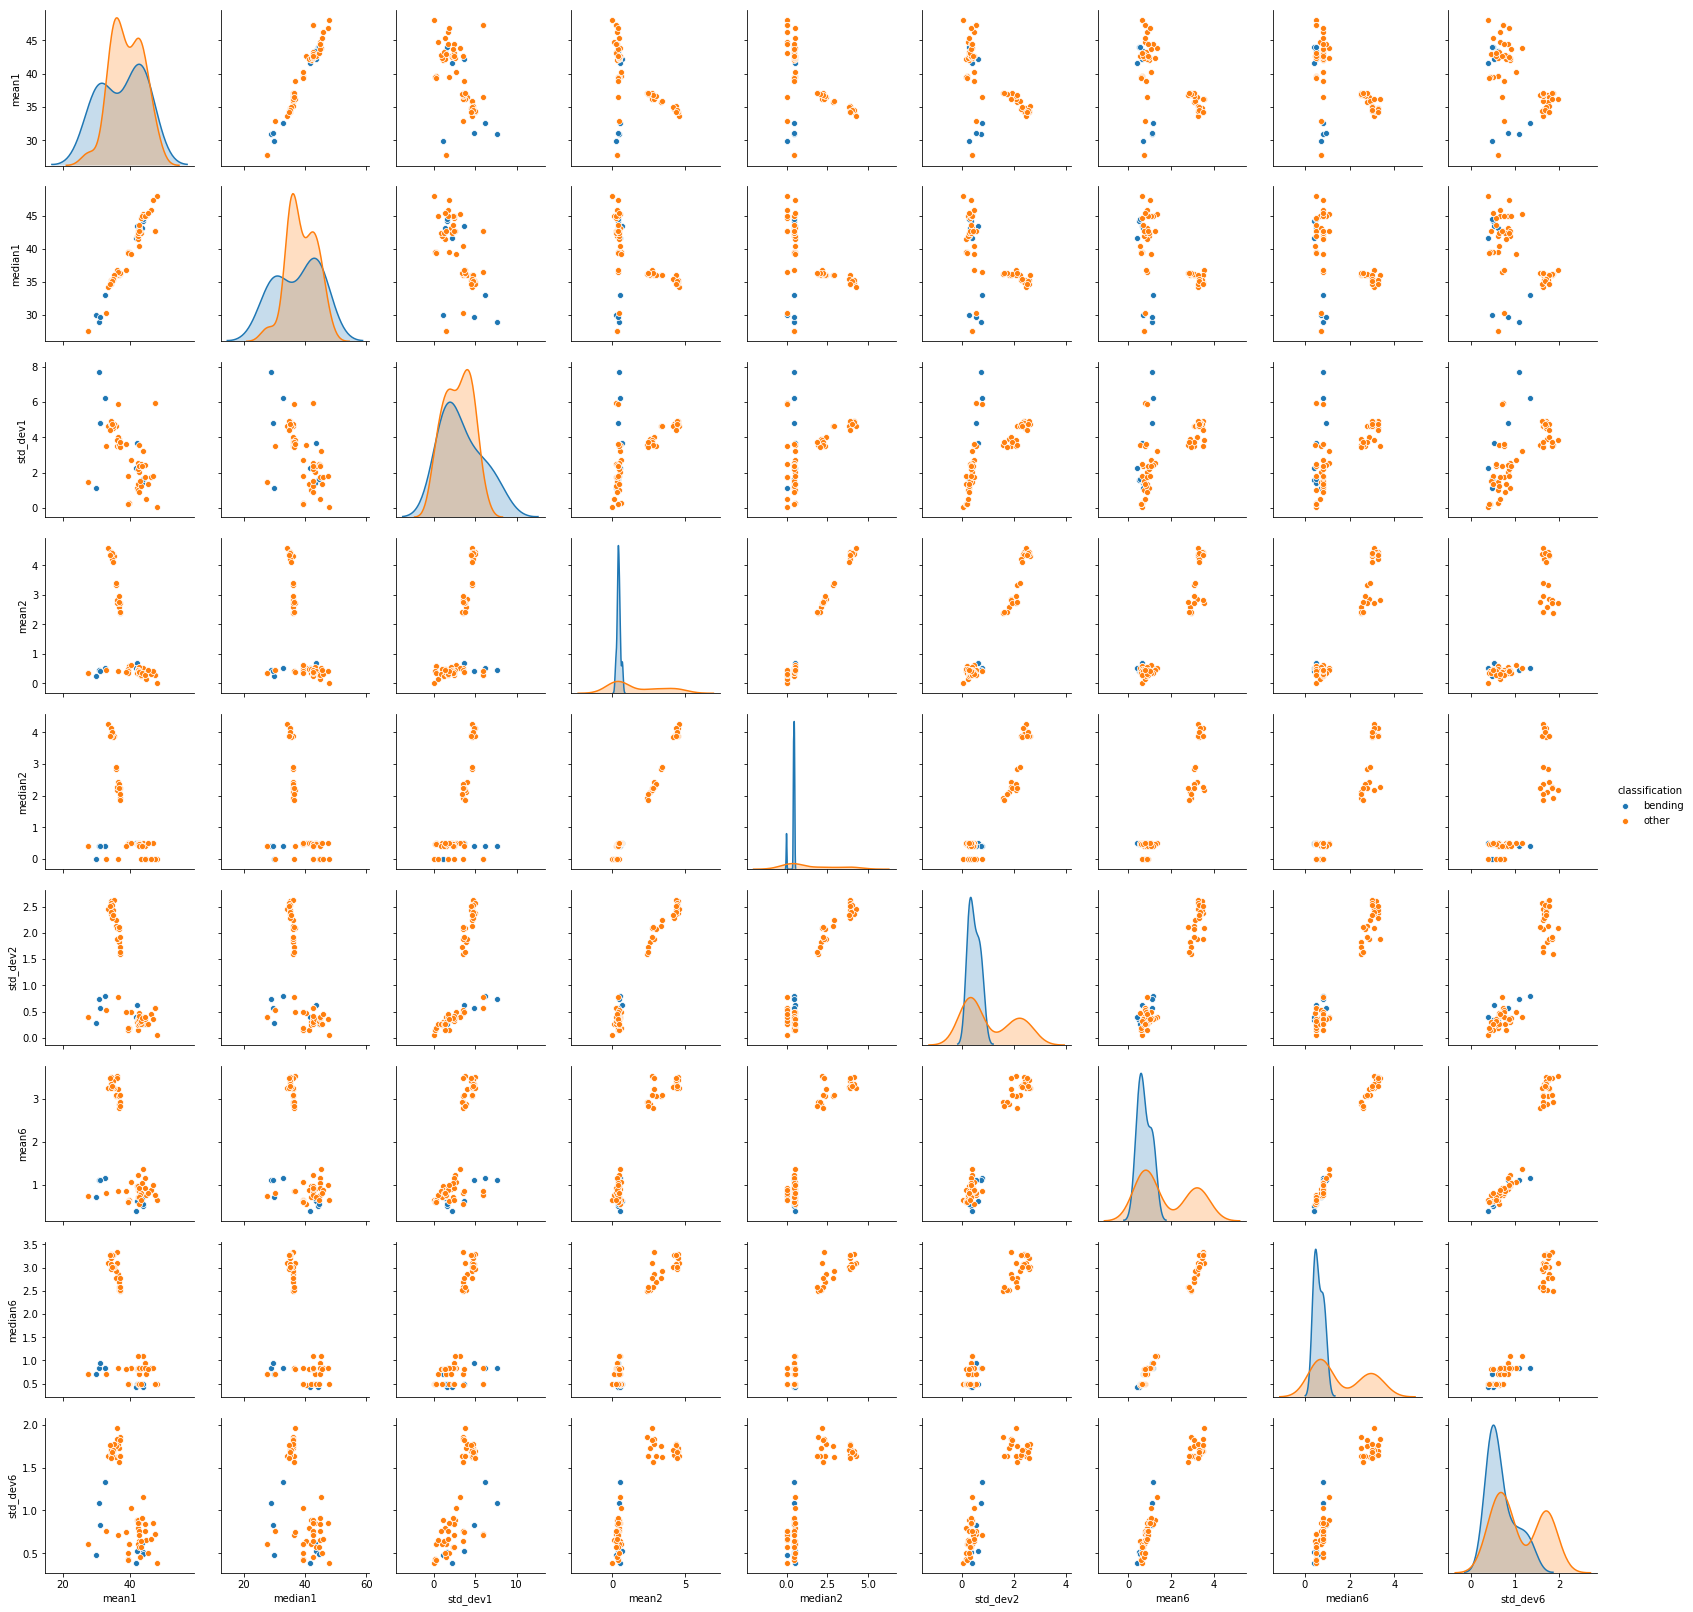

In [32]:
sns.pairplot(df_feat_tng126, hue='classification')

### Split Each Times Series in the Training Set into Two Equal Length Time Series

In [33]:
tng_split_dict = splitTimeSeries(training_dict, 2)
len(tng_split_dict)

69

In [34]:
# Get the features of the Training Set having 2 time series (tng_split_dict)
df_tng_feat_split = getFeatures(tng_split_dict)
df_tng_feat_split.head()

,min1,max1,mean1,median1,std_dev1,1st_quart1,3rd_quart1,min2,max2,mean2,...,std_dev11,1st_quart11,3rd_quart11,min12,max12,mean12,median12,std_dev12,1st_quart12,3rd_quart12
Instance,,,,,,,,,,,,,,,,,,,,,
1,36.50,46.50,44.057167,44.50,1.556971,43.2500,45.00,0.0,1.50,0.381042,...,2.298693,33.00,36.2500,0.0,1.50,0.388333,0.00,0.478528,0.0000,0.71
2,33.75,47.75,43.278875,45.00,3.473355,42.0000,45.25,0.0,3.00,0.673292,...,3.760118,28.75,33.7500,0.0,2.18,0.586083,0.47,0.491873,0.0000,0.87
3,33.00,45.75,41.621208,42.33,3.118644,39.6525,44.25,0.0,2.83,0.623083,...,2.062647,28.31,30.5625,0.0,1.50,0.347500,0.43,0.363144,0.0000,0.50
4,39.00,48.00,44.117042,45.00,1.359836,43.5000,45.00,0.0,1.30,0.250042,...,1.881721,22.50,23.7500,0.0,4.06,0.543875,0.50,0.473445,0.4300,0.71
5,36.67,45.00,43.486208,43.71,1.281976,42.3300,44.50,0.0,1.30,0.378667,...,1.929494,21.00,23.5000,0.0,2.96,0.585750,0.50,0.487918,0.4225,0.83


In [35]:
len(df_tng_feat_split)

69

### 2 (a) ii. Scatter Plots:  Mean, Median, and Standard Deviation (Time Series 1, 2, and 6)

In [36]:
# Get the features for time series 1, 2, and 12
df_featSplit_tng1 = df_tng_feat_split.loc[:,'mean1':'std_dev1']
df_featSplit_tng2 = df_tng_feat_split.loc[:,'mean2':'std_dev2']
df_featSplit_tng12 = df_tng_feat_split.loc[:,'mean6':'std_dev6']

df_feat_tng1212 = pd.concat([df_featSplit_tng1,df_featSplit_tng2,df_featSplit_tng12],axis=1)
tng_split_cols = classificationColumns(tng_split_dict)
df_feat_tng1212['classification']=tng_split_cols
df_feat_tng1212.head()

,mean1,median1,std_dev1,mean2,median2,std_dev2,mean12,median12,std_dev12,classification
Instance,,,,,,,,,,
1,44.057167,44.50,1.556971,0.381042,0.470,0.329540,0.388333,0.00,0.478528,bending
2,43.278875,45.00,3.473355,0.673292,0.485,0.634285,0.586083,0.47,0.491873,bending
3,41.621208,42.33,3.118644,0.623083,0.500,0.489595,0.347500,0.43,0.363144,bending
4,44.117042,45.00,1.359836,0.250042,0.000,0.314099,0.543875,0.50,0.473445,bending
5,43.486208,43.71,1.281976,0.378667,0.470,0.284434,0.585750,0.50,0.487918,bending


In [37]:
len(df_feat_tng1212)

69

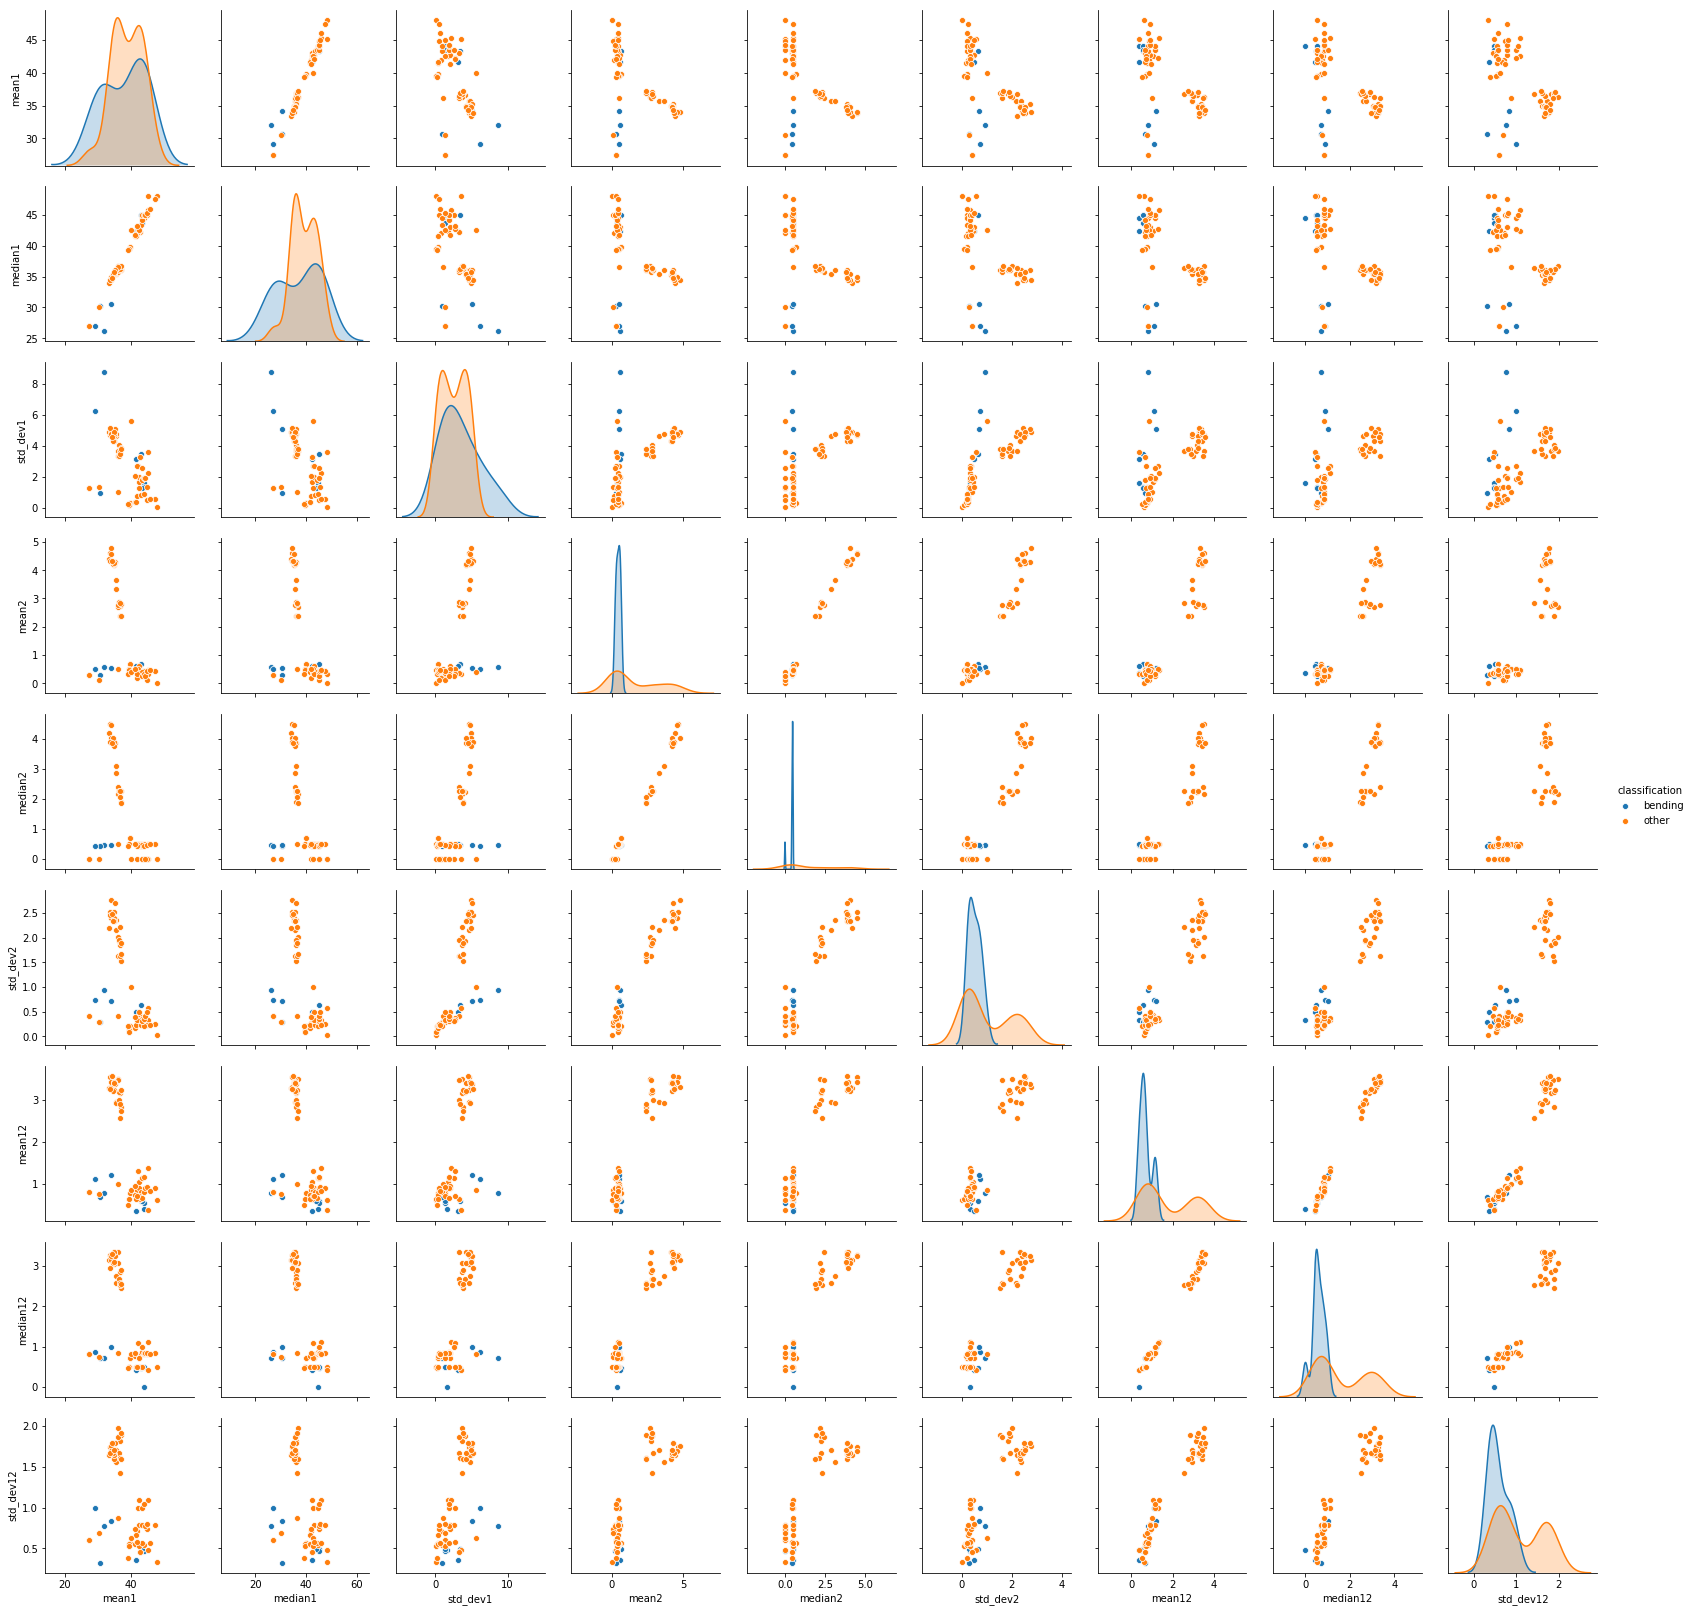

In [38]:
sns.pairplot(df_feat_tng1212, hue='classification')

### Do you see any considerable difference in the results with those of 2(a)i?
I do not see any considerable difference between the scatterplots in 2(a)i and 2(a)ii.

### 2 (a) iii. Break Each Time Series in both the Training Set and Test Set into $l \in$ {1,2,...,20} Time Series of Approximately Equal Length

In [39]:
numSeries = np.arange(1,21,1)
tng_nameSplit_list = []
tng_splitSeries_dict ={}

for num in numSeries:
    tng_name = 'tngSplit_dict' + str(num)
    tng_nameSplit_list.append(tng_name)
    vars()[tng_name] = splitTimeSeries(training_dict, num)
    tng_splitSeries_dict[tng_name]=vars()[tng_name]

In [40]:
len(tng_splitSeries_dict)

20

In [42]:
tng_splitSeries_dict[tng_nameSplit_list[18]]['bending1_dataset3'].tail()

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,avg_rss12,var_rss12,avg_rss13,var_rss13,...,avg_rss13,var_rss13,avg_rss23,var_rss23,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
21,45.0,0.0,21.00,0.00,37.00,1.00,43.75,0.43,24.25,0.43,...,19.33,0.47,36.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
22,45.0,0.0,22.75,0.83,36.50,0.50,44.75,0.43,23.75,0.43,...,18.50,0.50,36.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
23,45.0,0.0,24.00,0.00,36.25,0.43,45.00,0.00,24.00,0.00,...,18.00,0.00,36.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
24,45.0,0.0,23.25,0.83,36.75,0.83,45.00,0.00,24.00,0.00,...,18.25,0.43,36.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
25,45.0,0.0,23.75,0.43,37.00,1.00,44.50,0.50,23.75,0.43,...,19.00,0.00,36.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


#### Test Set Time Series Split

In [43]:
numSeries = np.arange(1,21,1)
test_nameSplit_list = []
test_splitSeries_dict ={}

for num in numSeries:
    test_name = 'testSplit_dict' + str(num)
    test_nameSplit_list.append(test_name)
    vars()[test_name] = splitTimeSeries(test_dict, num)
    
    # Create a dictionary for each Training Set with its new time series splits
    test_splitSeries_dict[test_name]=vars()[test_name]

In [44]:
len(test_splitSeries_dict)

20

In [46]:
test_splitSeries_dict[test_nameSplit_list[18]]['bending1_dataset1'].tail()

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,avg_rss12,var_rss12,avg_rss13,var_rss13,...,avg_rss13,var_rss13,avg_rss23,var_rss23,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
21,40.50,0.50,15.0,0.00,33.0,0.0,41.75,0.43,11.75,0.43,...,24.75,0.83,30.25,0.43,NaN,NaN,NaN,NaN,NaN,NaN
22,40.50,0.50,15.0,0.00,33.0,0.0,41.75,0.43,13.75,1.09,...,24.50,0.50,31.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN
23,40.33,0.47,16.0,0.00,33.0,0.0,41.50,0.50,13.50,1.50,...,24.00,0.00,29.33,0.94,NaN,NaN,NaN,NaN,NaN,NaN
24,40.50,0.50,16.0,0.71,33.0,0.0,41.50,0.50,13.33,1.25,...,24.33,0.47,27.25,0.43,NaN,NaN,NaN,NaN,NaN,NaN
25,40.50,0.50,16.5,0.87,33.0,0.0,41.50,0.50,16.25,1.30,...,25.00,0.00,29.75,0.43,NaN,NaN,NaN,NaN,NaN,NaN


### Get the Time-Domain Features for Each of the 20 Training Sets and 20 Test Sets
#### Time-Domain Features:  Training Set

In [47]:
tng_featAll_list = []
for num in range(0, len(tng_splitSeries_dict)):
    current_tngSetName = tng_nameSplit_list[num]
    tngSet = tng_splitSeries_dict[current_tngSetName]
    df_currentFeat = getFeatures(tngSet)
    tng_featAll_list.append(df_currentFeat)

In [48]:
tng_featAll_list[19].tail()

,min1,max1,mean1,median1,std_dev1,1st_quart1,3rd_quart1,min2,max2,mean2,...,std_dev119,1st_quart119,3rd_quart119,min120,max120,mean120,median120,std_dev120,1st_quart120,3rd_quart120
Instance,,,,,,,,,,,,,,,,,,,,,
65,25.50,42.75,34.902917,35.250,4.727315,32.9375,38.3125,0.43,9.07,3.792083,...,3.201525,12.2475,16.0625,1.09,7.85,3.524583,3.430,1.689497,2.0575,4.8100
66,25.50,41.75,34.423750,35.500,4.735547,30.0000,38.3125,0.00,8.31,4.566250,...,3.167375,14.2500,17.3750,0.43,5.35,2.922500,3.140,1.561266,1.5975,4.0600
67,25.25,41.50,34.336250,34.250,4.760912,30.3300,37.8750,0.00,10.06,3.552083,...,3.855169,14.6250,19.4075,0.00,7.07,3.257500,3.025,2.026151,1.7675,4.3675
68,24.25,44.00,36.288333,36.625,5.191574,33.6675,40.5000,1.12,12.38,4.891250,...,2.933286,14.1875,17.6250,0.50,8.15,3.511667,3.035,1.776087,2.4100,4.6800
69,23.75,42.75,34.604167,35.000,5.131011,32.4375,37.8750,0.83,10.50,4.245833,...,2.893191,14.1875,17.5000,0.83,5.56,3.542083,3.515,1.227518,2.6875,4.5150


#### Time-Domain Features:  Test Set

In [49]:
test_featAll_list = []
for num in range(0, len(test_splitSeries_dict)):
    current_testSetName = test_nameSplit_list[num]
    testSet = test_splitSeries_dict[current_testSetName]
    df_currentFeat = getFeatures(testSet)
    test_featAll_list.append(df_currentFeat)

In [50]:
test_featAll_list[19].tail()

,min1,max1,mean1,median1,std_dev1,1st_quart1,3rd_quart1,min2,max2,mean2,...,std_dev119,1st_quart119,3rd_quart119,min120,max120,mean120,median120,std_dev120,1st_quart120,3rd_quart120
Instance,,,,,,,,,,,,,,,,,,,,,
15,38.00,45.00,42.495833,43.585,2.398008,39.5000,44.3475,0.00,2.12,0.567083,...,1.724905,14.2500,15.2500,0.00,1.64,0.940417,1.090,0.475774,0.7100,1.3000
16,44.50,45.00,44.743333,44.750,0.209734,44.5000,45.0000,0.00,0.50,0.313333,...,1.379152,15.7500,18.0825,0.00,1.92,0.694167,0.710,0.363879,0.5000,0.8300
17,23.75,41.33,34.542917,35.875,4.257268,31.8750,37.1250,0.50,12.19,4.089167,...,2.739045,14.0625,16.7500,1.41,6.69,3.791667,3.715,1.756082,2.2100,5.1150
18,24.50,40.50,34.712500,36.250,5.015103,31.0000,38.7000,0.43,11.08,4.590417,...,2.966486,13.9375,18.5000,1.22,7.95,3.871667,3.265,1.903406,2.4400,5.3725
19,24.75,41.33,33.034167,33.375,4.235166,30.9575,34.9375,0.94,10.69,4.991250,...,2.755399,13.9375,18.6250,0.00,8.04,3.137500,2.975,1.924732,1.8425,4.0600


### Use logistic regression to solve the binary classification problem, using time-domain features

In [51]:
from sklearn import metrics
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score
import scipy.stats as stat

Binary values for the Instances in each of the time-domain feature dataframes:
* 1 = Bending
* 0 = Other (not bending)

#### Binary Column:  Training Set

In [52]:
tng_binaryCol = classificationBinaryColumns(training_dict)
for tngSet in tng_featAll_list:
    tngSet.insert(loc=0, column='binaryClass', value=tng_binaryCol)


In [53]:
tng_featAll_list[18].head()

,binaryClass,min1,max1,mean1,median1,std_dev1,1st_quart1,3rd_quart1,min2,max2,...,std_dev113,1st_quart113,3rd_quart113,min114,max114,mean114,median114,std_dev114,1st_quart114,3rd_quart114
Instance,,,,,,,,,,,,,,,,,,,,,
1,1,40.00,45.00,43.628077,44.415,1.612605,42.375,45.0000,0.0,0.87,...,0.284652,36.0000,36.2500,0.00,1.30,0.258333,0.000,0.393211,0.0000,0.4400
2,1,36.00,47.50,44.281923,45.000,3.219753,43.690,46.5000,0.0,3.00,...,2.482603,25.3150,29.8125,0.00,1.30,0.514167,0.430,0.449797,0.3225,0.6025
3,1,36.00,44.50,41.549231,42.000,2.083251,41.000,42.6875,0.0,1.22,...,1.726986,26.9375,30.0000,0.00,1.00,0.340833,0.215,0.389486,0.0000,0.5825
4,1,41.00,46.75,44.736923,45.000,1.188753,44.500,45.0000,0.0,1.30,...,4.962548,13.7500,22.2500,0.47,4.06,1.445000,1.015,1.148861,0.7475,1.5875
5,1,40.75,44.25,42.810769,42.875,0.921542,42.000,43.5000,0.0,0.94,...,1.019446,23.1850,24.0000,0.00,1.73,0.661667,0.665,0.528907,0.3225,0.9400


In [54]:
bendingNum=0
otherNum=0
for item in tng_binaryCol:
    if item==1:
        bendingNum+=1
    else:
        otherNum+=1
print('In the Training Sets, there are {} Instances for bending activities and {} Instances for other activities'.format(bendingNum,otherNum))

In the Training Sets, there are 9 Instances for bending activities and 60 Instances for other activities


#### Binary Column:  Test Set

In [55]:
test_binaryCol = classificationBinaryColumns(test_dict)
for testSet in test_featAll_list:
    testSet.insert(loc=0, column='binaryClass', value=test_binaryCol)

In [56]:
test_featAll_list[19].tail()

,binaryClass,min1,max1,mean1,median1,std_dev1,1st_quart1,3rd_quart1,min2,max2,...,std_dev119,1st_quart119,3rd_quart119,min120,max120,mean120,median120,std_dev120,1st_quart120,3rd_quart120
Instance,,,,,,,,,,,,,,,,,,,,,
15,0,38.00,45.00,42.495833,43.585,2.398008,39.5000,44.3475,0.00,2.12,...,1.724905,14.2500,15.2500,0.00,1.64,0.940417,1.090,0.475774,0.7100,1.3000
16,0,44.50,45.00,44.743333,44.750,0.209734,44.5000,45.0000,0.00,0.50,...,1.379152,15.7500,18.0825,0.00,1.92,0.694167,0.710,0.363879,0.5000,0.8300
17,0,23.75,41.33,34.542917,35.875,4.257268,31.8750,37.1250,0.50,12.19,...,2.739045,14.0625,16.7500,1.41,6.69,3.791667,3.715,1.756082,2.2100,5.1150
18,0,24.50,40.50,34.712500,36.250,5.015103,31.0000,38.7000,0.43,11.08,...,2.966486,13.9375,18.5000,1.22,7.95,3.871667,3.265,1.903406,2.4400,5.3725
19,0,24.75,41.33,33.034167,33.375,4.235166,30.9575,34.9375,0.94,10.69,...,2.755399,13.9375,18.6250,0.00,8.04,3.137500,2.975,1.924732,1.8425,4.0600


In [57]:
bendingNum=0
otherNum=0
for item in test_binaryCol:
    if item==1:
        bendingNum+=1
    else:
        otherNum+=1
print('In the Test Sets, there are {} Instances for bending activities and {} Instances for other activities'.format(bendingNum,otherNum))

In the Test Sets, there are 4 Instances for bending activities and 15 Instances for other activities


#### Calculate the p-values for your logistic regression parameters in each model corresponding to each value of $\mathit{l}$ and refit a logistic regression model using your pruned set of features. Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair ($\mathit{l}$, $\mathit{p}$) , where $\mathit{p}$ is the number of features used in recursive feature elimination.

In [58]:
rfeCV_scores=[]
l_list=[]
pNum_feature_list=[]
rfeCV_dict={}
test_score_list=[]
confusion_list=[]
fpr_list=[]
tpr_list=[]
thresholds_list=[]
auc_list=[]
rocauc_score_list=[]
features_selected_list=[]
rfeCV_testScores_list=[]
confusion_rfeCV_list=[]

for l in range(len(tng_featAll_list)):
    l_list.append(l+1)
    
    X_train = tng_featAll_list[l].iloc[:,1:]
    y_train = tng_featAll_list[l].loc[:,'binaryClass']
    X_test = test_featAll_list[l].iloc[:,1:]
    y_test = test_featAll_list[l].loc[:,'binaryClass']

    logReg_tng = LogisticRegression(solver='liblinear',random_state=19)
    
    rfeCV = RFECV(logReg_tng, step=1, min_features_to_select=1, cv=5, scoring='accuracy')
    rfeCV = rfeCV.fit(X_train, y_train)
    
    pNum_features = rfeCV.n_features_
    pNum_feature_list.append(pNum_features)  
    
    bestScore_rfeCV = np.amax(rfeCV.grid_scores_)
    rfeCV_scores.append(bestScore_rfeCV)
    
    test_score = rfeCV.score(X_test, y_test)
    test_score_list.append(test_score)
    
    ytest_pred = rfeCV.predict(X_test)
    confusion = confusion_matrix(y_test, ytest_pred)
    confusion_list.append(confusion)
    
    features_selected = [f for f,s in zip(X_train.columns, rfeCV.support_) if s]
    features_selected_list.append(features_selected)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, ytest_pred)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    thresholds_list.append(thresholds)
    
    auc = metrics.auc(fpr, tpr)
    auc_list.append(auc)
    
rfeCV_dict = {'l':l_list, 
              'p':pNum_feature_list, 
              'CV_Score':rfeCV_scores, 
              'Test_Score':test_score_list,
              'Confusion_Matrix':confusion_list,
              'FP_Rates':fpr_list,
              'TP_Rates':tpr_list,
              'Thresholds':thresholds_list,
              'AUC':auc_list,
              'Features_Selected':features_selected_list
             }
df_rfeCV = pd.DataFrame(rfeCV_dict)
df_rfeCV

,l,p,CV_Score,Test_Score,Confusion_Matrix,FP_Rates,TP_Rates,Thresholds,AUC,Features_Selected
0,1,4,0.985714,1.000000,"[[15, 0], [0, 4]]","[0.0, 0.0, 1.0]","[0.0, 1.0, 1.0]","[2, 1, 0]",1.000,"[3rd_quart1, max2, min5, max5]"
1,2,4,0.985714,1.000000,"[[15, 0], [0, 4]]","[0.0, 0.0, 1.0]","[0.0, 1.0, 1.0]","[2, 1, 0]",1.000,"[median1, min5, max5, max12]"
2,3,4,1.000000,1.000000,"[[15, 0], [0, 4]]","[0.0, 0.0, 1.0]","[0.0, 1.0, 1.0]","[2, 1, 0]",1.000,"[min5, 3rd_quart5, 3rd_quart7, max18]"
3,4,5,0.985714,0.947368,"[[15, 0], [1, 3]]","[0.0, 0.0, 1.0]","[0.0, 0.75, 1.0]","[2, 1, 0]",0.875,"[mean5, 1st_quart5, 3rd_quart5, 3rd_quart13, max18]"
4,5,19,0.985714,1.000000,"[[15, 0], [0, 4]]","[0.0, 0.0, 1.0]","[0.0, 1.0, 1.0]","[2, 1, 0]",1.000,"[min3, min5, max5, mean5, median5, 1st_quart5, 3rd_quart5, max8, min11, max12, 3rd_quart13, max18, mean19, median19, 3rd_quart19, max20, 3rd_quart27, median29, 1st_quart29]"
5,6,5,0.971429,1.000000,"[[15, 0], [0, 4]]","[0.0, 0.0, 1.0]","[0.0, 1.0, 1.0]","[2, 1, 0]",1.000,"[3rd_quart5, max8, min11, median19, max36]"
6,7,22,0.985714,1.000000,"[[15, 0], [0, 4]]","[0.0, 0.0, 1.0]","[0.0, 1.0, 1.0]","[2, 1, 0]",1.000,"[min3, max5, mean5, 3rd_quart5, max8, min11, max11, mean11, 1st_quart11, 3rd_quart11, max19, 3rd_quart19, max20, max25, mean25, 3rd_quart25, min27, min29, min35, min39, 1st_quart41, max42]"
7,8,4,0.985714,0.947368,"[[15, 0], [1, 3]]","[0.0, 0.0, 1.0]","[0.0, 0.75, 1.0]","[2, 1, 0]",0.875,"[3rd_quart5, 3rd_quart11, max31, min41]"
8,9,4,0.957143,0.947368,"[[15, 0], [1, 3]]","[0.0, 0.0, 1.0]","[0.0, 0.75, 1.0]","[2, 1, 0]",0.875,"[mean11, median11, max25, min47]"
9,10,13,0.971429,0.947368,"[[15, 0], [1, 3]]","[0.0, 0.0, 1.0]","[0.0, 0.75, 1.0]","[2, 1, 0]",0.875,"[max5, mean11, median11, 1st_quart11, 3rd_quart11, 1st_quart17, min19, max25, max31, median31, 3rd_quart31, max43, min53]"


In [59]:
df_rfeCV_min = df_rfeCV.copy()
df_rfeCV_min = df_rfeCV_min[df_rfeCV_min['Test_Score']==df_rfeCV_min['Test_Score'].max()] # highest test score
df_rfeCV_min = df_rfeCV_min[df_rfeCV_min['CV_Score']==df_rfeCV_min['CV_Score'].max()] # highest CV score
df_rfeCV_min

,l,p,CV_Score,Test_Score,Confusion_Matrix,FP_Rates,TP_Rates,Thresholds,AUC,Features_Selected
2,3,4,1.0,1.0,"[[15, 0], [0, 4]]","[0.0, 0.0, 1.0]","[0.0, 1.0, 1.0]","[2, 1, 0]",1.0,"[min5, 3rd_quart5, 3rd_quart7, max18]"


#### Use 5-fold cross-validation to determine the best value of the pair ($\mathit{l}$, $\mathit{p}$)
The dataframe output above shows that best value are : $\mathit{l}$ = 3 and $\mathit{p}$ = 4, where $\mathit{l}$ is the number of times the time series was split and $\mathit{p}$ is the number of features selected used in recursive feature elimination.

#### Explain the right way and wrong way to do cross validation in this problem
The _right way_ to do cross-validation in this problem is to apply cross-validation to both the trained model and feature selection. RFECV does exactly this and allows us to obtain the test score via the '.score()' method because it refits the model with the model we passed in and the reduced feature set to return the score.

Additionally, the proper way to do cross-validation is to start by taking each of the $\mathit{l}$ split time series dataframes and dividing the number of observations as evenly as possible into k-folds.

The _wrong way_ to do cross-validation in this problem would be to perform the cross-validation after feature selection because those features are part of the model.

#### Report the confusion matrix
For this scenario where $\mathit{l}$ = 3 and $\mathit{p}$ = 4, our confusion matrix resulted in

TP = 15   FN = 0

FP = 0    TN = 4

Confusion Matrix
[[15  0]
 [ 0  4]]


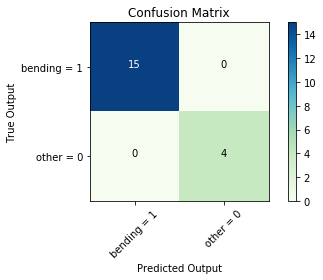

In [60]:
activities=['bending = 1','other = 0']
plot_confusion_matrix(confusion_list[2], classes=activities,
                      normalize=False,
                      title='Confusion Matrix',
                      c_map=plt.get_cmap("GnBu"))

#### Test the classifer on the test set
In testing the classifier on the test set using the features extracted from the test set, the accuracy (Test_Score) resulted in 1.0, which is 100%. In comparing the accuracy against the cross validation score (CV_score), we see they have the same value. Thus, for $\mathit{l}$ = 3 and $\mathit{p}$ = 4, the accuracy and cross validation scores are equivalent at 100%.

### ROC Plot
For our best case scenario where $\mathit{l}$ = 3 and $\mathit{p}$ = 4, the receiver operating characteristic (ROC) curve is shown below in green.

The confusion matrix is: 
[[15  0]
 [ 0  4]]
The AUC is: 1.0


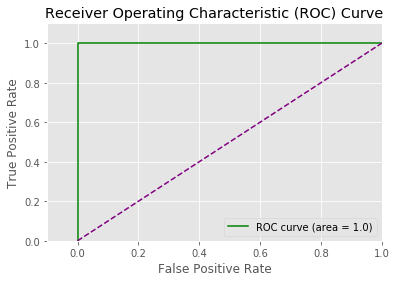

In [61]:
print('The confusion matrix is: ')
print(confusion_list[2])
print('The AUC is: {}'.format(auc_list[2]))

plt.style.use('ggplot')
plt.plot(fpr_list[2], tpr_list[2], color='green', label='ROC curve (area = {})'.format(auc_list[2]))
plt.plot([0, 1], [0, 1], color='purple', linestyle='--')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Parameters for the Logistic Regression $\beta_i$'s and P-Values
For our best case scenario where $\mathit{l}$ = 3 and $\mathit{p}$ = 4, the dataframe below shows the features selected along with their $\beta_i$'s and p-values. For the p-values, the calculations completed below came from the formula provided by Mr. Rob Speare at https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d. 


In [62]:
X_trainBest = tng_featAll_list[2].iloc[:,1:]
y_trainBest = tng_featAll_list[2].loc[:,'binaryClass']
X_testBest = test_featAll_list[2].iloc[:,1:]
y_testBest = test_featAll_list[2].loc[:,'binaryClass']

# logistic regression model
logReg_tngBest = LogisticRegression(solver='liblinear',random_state=19)

# Use backwards selection with 5-folds cross-validation to select the best features
rfeCVBest = RFECV(logReg_tngBest, step=1, min_features_to_select=1, cv=5)
rfeCVBest = rfeCVBest.fit(X_trainBest, y_trainBest)

features_selectedBest = [f for f,s in zip(X_trainBest.columns, rfeCVBest.support_) if s]

X_trainNewBest = tng_featAll_list[2][features_selectedBest]
X_testNewBest = test_featAll_list[2][features_selectedBest]

logReg_tngBestFinal = LogisticRegression(solver='liblinear',random_state=19)
logReg_tngBestFinal.fit(X_trainNewBest, y_trainBest)
coefBest = logReg_tngBestFinal.coef_
interceptBest = logReg_tngBestFinal.intercept_
print('The y-intercept for our model is: {}'.format(interceptBest))

denom = (2.0*(1.0+np.cosh(logReg_tngBestFinal.decision_function(X_trainNewBest))))
denom = np.tile(denom,(X_trainNewBest.shape[1],1)).T
F_ij = np.dot((X_trainNewBest/denom).T,X_trainNewBest)
Cramer_Rao = np.linalg.inv(F_ij)
sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
z_scores = logReg_tngBestFinal.coef_[0]/sigma_estimates
p_values = [stat.norm.sf(abs(x))*2 for x in z_scores]

df_logRegBest = pd.DataFrame({'p_Feature_Selected':features_selectedBest,
                              'Coefficient':coefBest.ravel(),
                              'p-values':p_values
                             })
df_logRegBest

The y-intercept for our model is: [-0.01224163]


,p_Feature_Selected,Coefficient,p-values
0,min5,0.529609,0.410937
1,3rd_quart5,0.842770,0.095601
2,3rd_quart7,-0.556493,0.065997
3,max18,-0.469299,0.460473


The calculated p-values, we can see that none of them are below 0.05.

### 2 (a) vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

Yes, it appears that the classes are well-separated to cause instability because we are getting perfect scores. Complete separation is a way of saying there is a perfect prediction.

### 2 (a) vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

There are 9 Instances in our Training Set that are classified as 'bending' and 60 Instances that are classified as 'other', which indicates that approximately 13% (9/69) are 'bending' activities. Because of the small percentage of 'bending' activities, we can say that the classes are imbalanced.

In [63]:
from imblearn.over_sampling import SMOTE

In [64]:
# Logistic regression + RFECV with SMOTE
rfeCVSMOTE_scores=[]
l_list=[]
pNumSMOTE_feature_list=[]
rfeCVSMOTE_dict={}
test_scoreSMOTE_list=[]
confusionSMOTE_list=[]
fprSMOTE_list=[]
tprSMOTE_list=[]
thresholdsSMOTE_list=[]
aucSMOTE_list=[]
rocauc_scoreSMOTE_list=[]
features_selectedSMOTE_list=[]
rfeCVSMOTE_testScores_list=[]
confusion_rfeCVSMOTE_list=[]

for l in range(len(tng_featAll_list)):
    l_list.append(l+1)
    
    X_train = tng_featAll_list[l].iloc[:,1:]
    y_train = tng_featAll_list[l].loc[:,'binaryClass']
    X_test = test_featAll_list[l].iloc[:,1:]
    y_test = test_featAll_list[l].loc[:,'binaryClass']
    
    # Resample the Training Set with SMOTE
    sm = SMOTE(random_state=19)
    X_trainResampled, y_trainResampled = sm.fit_resample(X_train, y_train)

    logRegSMOTE_tng = LogisticRegression(solver='liblinear',random_state=19)
    
    # Use backward selection with a logistic regression model and 5-folds CV
    rfeCVSMOTE = RFECV(logRegSMOTE_tng, step=1, min_features_to_select=1, cv=5, scoring='accuracy')
    rfeCVSMOTE = rfeCVSMOTE.fit(X_trainResampled, y_trainResampled)
    
    pNumSMOTE_features = rfeCVSMOTE.n_features_
    pNumSMOTE_feature_list.append(pNumSMOTE_features)  
    
    bestScore_rfeCVSMOTE = np.amax(rfeCVSMOTE.grid_scores_)
    rfeCVSMOTE_scores.append(bestScore_rfeCVSMOTE)
    
    test_scoreSMOTE = rfeCVSMOTE.score(X_test, y_test)
    test_scoreSMOTE_list.append(test_scoreSMOTE)
    
    ytestSMOTE_pred = rfeCVSMOTE.predict(X_test)
    confusionSMOTE = confusion_matrix(y_test, ytestSMOTE_pred)
    confusionSMOTE_list.append(confusionSMOTE)
    
    features_selectedSMOTE = [f for f,s in zip(X_train.columns, rfeCVSMOTE.support_) if s]
    features_selectedSMOTE_list.append(features_selectedSMOTE)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, ytestSMOTE_pred)
    fprSMOTE_list.append(fpr)
    tprSMOTE_list.append(tpr)
    thresholdsSMOTE_list.append(thresholds)
    
    aucSMOTE = metrics.auc(fpr, tpr)
    aucSMOTE_list.append(aucSMOTE)
    
rfeCVSMOTE_dict = {'l':l_list, 
                  'p':pNumSMOTE_feature_list, 
                  'CV_Score':rfeCVSMOTE_scores, 
                  'Test_Score':test_scoreSMOTE_list,
                  'Confusion_Matrix':confusionSMOTE_list,
                  'FP_Rates':fprSMOTE_list,
                  'TP_Rates':tprSMOTE_list,
                  'Thresholds':thresholdsSMOTE_list,
                  'AUC':aucSMOTE_list,
                  'Features_Selected':features_selectedSMOTE_list
             }
df_rfeCVSMOTE = pd.DataFrame(rfeCVSMOTE_dict)
df_rfeCVSMOTE

,l,p,CV_Score,Test_Score,Confusion_Matrix,FP_Rates,TP_Rates,Thresholds,AUC,Features_Selected
0,1,13,0.983333,1.000000,"[[15, 0], [0, 4]]","[0.0, 0.0, 1.0]","[0.0, 1.0, 1.0]","[2, 1, 0]",1.000,"[mean1, 3rd_quart1, max2, 3rd_quart2, min3, max3, median3, min5, max5, mean5, 1st_quart5, max6, 3rd_quart6]"
1,2,6,0.991667,1.000000,"[[15, 0], [0, 4]]","[0.0, 0.0, 1.0]","[0.0, 1.0, 1.0]","[2, 1, 0]",1.000,"[median1, max2, min5, max5, 1st_quart11, max12]"
2,3,5,0.991667,1.000000,"[[15, 0], [0, 4]]","[0.0, 0.0, 1.0]","[0.0, 1.0, 1.0]","[2, 1, 0]",1.000,"[min5, max5, 3rd_quart5, 3rd_quart7, max18]"
3,4,5,1.000000,1.000000,"[[15, 0], [0, 4]]","[0.0, 0.0, 1.0]","[0.0, 1.0, 1.0]","[2, 1, 0]",1.000,"[mean5, 1st_quart5, 3rd_quart5, 3rd_quart13, max18]"
4,5,4,1.000000,1.000000,"[[15, 0], [0, 4]]","[0.0, 0.0, 1.0]","[0.0, 1.0, 1.0]","[2, 1, 0]",1.000,"[max5, 3rd_quart5, max8, 3rd_quart13]"
5,6,4,0.991667,1.000000,"[[15, 0], [0, 4]]","[0.0, 0.0, 1.0]","[0.0, 1.0, 1.0]","[2, 1, 0]",1.000,"[3rd_quart5, min11, median19, max36]"
6,7,4,1.000000,0.947368,"[[15, 0], [1, 3]]","[0.0, 0.0, 1.0]","[0.0, 0.75, 1.0]","[2, 1, 0]",0.875,"[max5, 3rd_quart5, max19, max42]"
7,8,3,0.991667,0.947368,"[[15, 0], [1, 3]]","[0.0, 0.0, 1.0]","[0.0, 0.75, 1.0]","[2, 1, 0]",0.875,"[max5, 3rd_quart25, max48]"
8,9,9,1.000000,1.000000,"[[15, 0], [0, 4]]","[0.0, 0.0, 1.0]","[0.0, 1.0, 1.0]","[2, 1, 0]",1.000,"[max5, median11, 1st_quart11, 3rd_quart11, min17, max25, max26, 3rd_quart37, min47]"
9,10,4,1.000000,0.947368,"[[15, 0], [1, 3]]","[0.0, 0.0, 1.0]","[0.0, 0.75, 1.0]","[2, 1, 0]",0.875,"[mean11, 1st_quart11, 3rd_quart31, min53]"


In [65]:
# Find the value of l with the highest CV and test scores
df_rfeCVSMOTE_min = df_rfeCVSMOTE.copy()
df_rfeCVSMOTE_min = df_rfeCVSMOTE_min[df_rfeCVSMOTE_min['Test_Score']==df_rfeCVSMOTE_min['Test_Score'].max()]
df_rfeCVSMOTE_min = df_rfeCVSMOTE_min[df_rfeCVSMOTE_min['CV_Score']==df_rfeCVSMOTE_min['CV_Score'].max()]
df_rfeCVSMOTE_min = df_rfeCVSMOTE_min[df_rfeCVSMOTE_min['l']==df_rfeCVSMOTE_min['l'].min()]
df_rfeCVSMOTE_min

,l,p,CV_Score,Test_Score,Confusion_Matrix,FP_Rates,TP_Rates,Thresholds,AUC,Features_Selected
3,4,5,1.0,1.0,"[[15, 0], [0, 4]]","[0.0, 0.0, 1.0]","[0.0, 1.0, 1.0]","[2, 1, 0]",1.0,"[mean5, 1st_quart5, 3rd_quart5, 3rd_quart13, max18]"


Based on the dataframe above, our best case is for $\mathit{l}$ = 4 and $\mathit{p}$ = 5.
#### Confusion Matrix for  $\mathit{l}$ = 4 and $\mathit{p}$ = 5

Confusion Matrix
[[15  0]
 [ 0  4]]


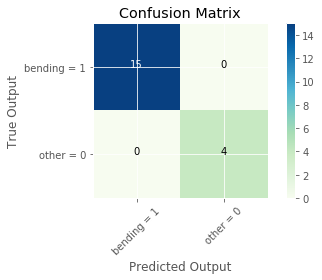

In [66]:
# Confusion Matrix
activities=['bending = 1','other = 0']
plot_confusion_matrix(confusionSMOTE_list[3], classes=activities,
                      normalize=False,
                      title='Confusion Matrix',
                      c_map=plt.get_cmap("GnBu"))

#### ROC and AUC for $\mathit{l}$ = 4 and $\mathit{p}$ = 5

The confusion matrix is: 
[[15  0]
 [ 0  4]]
The AUC is: 1.0


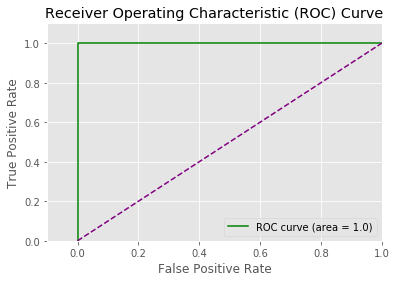

In [67]:
# ROC
print('The confusion matrix is: ')
print(confusionSMOTE_list[3])
print('The AUC is: {}'.format(aucSMOTE_list[3]))

plt.style.use('ggplot')
plt.plot(fprSMOTE_list[3], tprSMOTE_list[3], color='green', label='ROC curve (area = {})'.format(aucSMOTE_list[3]))
plt.plot([0, 1], [0, 1], color='purple', linestyle='--')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [68]:
from sklearn.utils import resample

In [69]:
# Logistic regression + RFECV and  downsampling
rfeCVDown_scores=[]
l_list=[]
pNumDown_feature_list=[]
rfeCVdown_dict={}
test_scoreDown_list=[]
confusionDown_list=[]
fprDown_list=[]
tprDown_list=[]
thresholdsDown_list=[]
aucDown_list=[]
rocauc_scoreDown_list=[]
features_selectedDown_list=[]
rfeCVDown_testScores_list=[]
confusion_rfeCVDown_list=[]

for l in range(len(tng_featAll_list)):
    l_list.append(l+1)
    
    # Resample the Training Set by downsampling
    minority = tng_featAll_list[l][tng_featAll_list[l]['binaryClass']==1]
    majority = tng_featAll_list[l][tng_featAll_list[l]['binaryClass']==0]
    majorityResample = resample(majority, 
                                replace=False,
                                n_samples=21,
                                random_state=19) 
    tngSet_new = pd.concat([minority, majorityResample])
    
    
    X_train = tngSet_new.iloc[:,1:]
    y_train = tngSet_new.loc[:,'binaryClass']
    X_test = test_featAll_list[l].iloc[:,1:]
    y_test = test_featAll_list[l].loc[:,'binaryClass']


    logRegDown_tng = LogisticRegression(solver='liblinear',random_state=19)
    
    rfeCVDown = RFECV(logRegDown_tng, step=1, min_features_to_select=1, cv=5, scoring='accuracy')
    rfeCVDown = rfeCVDown.fit(X_train, y_train)  # Fit the model on the Training Set
    
    pNumDown_features = rfeCVDown.n_features_
    pNumDown_feature_list.append(pNumDown_features)  
    
    bestScore_rfeCVDown = np.amax(rfeCVDown.grid_scores_)
    rfeCVDown_scores.append(bestScore_rfeCVDown)
    
    test_scoreDown = rfeCVDown.score(X_test, y_test)
    test_scoreDown_list.append(test_scoreDown)
    
    ytestDown_pred = rfeCVDown.predict(X_test)
    confusionDown = confusion_matrix(y_test, ytestDown_pred)
    confusionDown_list.append(confusionDown)
    
    features_selectedDown = [f for f,s in zip(X_train.columns, rfeCVDown.support_) if s]
    features_selectedDown_list.append(features_selectedDown)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, ytestDown_pred)
    fprDown_list.append(fpr)
    tprDown_list.append(tpr)
    thresholdsDown_list.append(thresholds)
    
    aucDown = metrics.auc(fpr, tpr)
    aucDown_list.append(aucDown)
    
rfeCVDown_dict = {'l':l_list, 
                  'p':pNumDown_feature_list, 
                  'CV_Score':rfeCVDown_scores, 
                  'Test_Score':test_scoreDown_list,
                  'Confusion_Matrix':confusionDown_list,
                  'FP_Rates':fprDown_list,
                  'TP_Rates':tprDown_list,
                  'Thresholds':thresholdsDown_list,
                  'AUC':aucDown_list,
                  'Features_Selected':features_selectedDown_list
             }
df_rfeCVDown = pd.DataFrame(rfeCVDown_dict)
df_rfeCVDown

,l,p,CV_Score,Test_Score,Confusion_Matrix,FP_Rates,TP_Rates,Thresholds,AUC,Features_Selected
0,1,9,0.971429,1.000000,"[[15, 0], [0, 4]]","[0.0, 0.0, 1.0]","[0.0, 1.0, 1.0]","[2, 1, 0]",1.000,"[mean1, 3rd_quart1, max2, 3rd_quart2, median3, min5, max5, mean5, 1st_quart5]"
1,2,13,0.966667,1.000000,"[[15, 0], [0, 4]]","[0.0, 0.0, 1.0]","[0.0, 1.0, 1.0]","[2, 1, 0]",1.000,"[max2, 1st_quart3, min5, max5, mean5, median5, 3rd_quart5, mean7, median7, max8, min11, 1st_quart11, max12]"
2,3,9,0.971429,0.947368,"[[15, 0], [1, 3]]","[0.0, 0.0, 1.0]","[0.0, 0.75, 1.0]","[2, 1, 0]",0.875,"[1st_quart3, min5, max5, mean5, 3rd_quart5, max7, 3rd_quart7, max14, min17]"
3,4,10,0.966667,0.947368,"[[15, 0], [1, 3]]","[0.0, 0.0, 1.0]","[0.0, 0.75, 1.0]","[2, 1, 0]",0.875,"[min3, 1st_quart3, max5, mean5, 1st_quart5, 3rd_quart5, median13, 3rd_quart13, min17, max20]"
4,5,8,0.938095,1.000000,"[[15, 0], [0, 4]]","[0.0, 0.0, 1.0]","[0.0, 1.0, 1.0]","[2, 1, 0]",1.000,"[min3, max5, mean5, median5, 3rd_quart5, max13, 3rd_quart19, 1st_quart29]"
5,6,9,0.938095,0.947368,"[[15, 0], [1, 3]]","[0.0, 0.0, 1.0]","[0.0, 0.75, 1.0]","[2, 1, 0]",0.875,"[min3, mean5, 3rd_quart5, max11, 3rd_quart19, min23, 3rd_quart25, min29, max32]"
6,7,9,0.971429,0.947368,"[[15, 0], [1, 3]]","[0.0, 0.0, 1.0]","[0.0, 0.75, 1.0]","[2, 1, 0]",0.875,"[min3, max5, 3rd_quart5, min11, max11, max19, max25, min29, min35]"
7,8,17,0.898095,0.947368,"[[15, 0], [1, 3]]","[0.0, 0.0, 1.0]","[0.0, 0.75, 1.0]","[2, 1, 0]",0.875,"[1st_quart3, min5, max5, 3rd_quart5, min9, max11, 3rd_quart11, min17, median25, 3rd_quart25, min29, max31, 3rd_quart31, min35, max38, min41, max44]"
8,9,38,0.931429,0.947368,"[[15, 0], [1, 3]]","[0.0, 0.0, 1.0]","[0.0, 0.75, 1.0]","[2, 1, 0]",0.875,"[min3, 1st_quart3, min5, max5, mean5, 1st_quart5, 3rd_quart5, min9, 1st_quart9, max11, mean11, median11, 1st_quart11, 3rd_quart11, min17, max17, mean17, median17, 1st_quart17, 3rd_quart17, max25, max26, min27, max30, max31, 3rd_quart31, min35, max37, mean37, median37, 3rd_quart37, max44, min47, 1st_quart47, max48, max49, max50, min53]"
9,10,15,0.904762,0.947368,"[[15, 0], [1, 3]]","[0.0, 0.0, 1.0]","[0.0, 0.75, 1.0]","[2, 1, 0]",0.875,"[min3, max5, mean11, median11, 1st_quart11, 3rd_quart11, max17, max25, max31, min35, max43, 3rd_quart43, max50, min53, 1st_quart53]"


In [70]:
df_rfeCVDown_min = df_rfeCVDown.copy()
df_rfeCVDown_min = df_rfeCVDown_min[df_rfeCVDown_min['Test_Score']==df_rfeCVDown_min['Test_Score'].max()]
df_rfeCVDown_min = df_rfeCVDown_min[df_rfeCVDown_min['CV_Score']==df_rfeCVDown_min['CV_Score'].max()]
df_rfeCVDown_min = df_rfeCVDown_min[df_rfeCVDown_min['l']==df_rfeCVDown_min['l'].min()]
df_rfeCVDown_min

,l,p,CV_Score,Test_Score,Confusion_Matrix,FP_Rates,TP_Rates,Thresholds,AUC,Features_Selected
19,20,11,1.0,1.0,"[[15, 0], [0, 4]]","[0.0, 0.0, 1.0]","[0.0, 1.0, 1.0]","[2, 1, 0]",1.0,"[min11, min17, mean17, 1st_quart17, min35, max51, max61, 3rd_quart67, max91, min107, min113]"


Based on the dataframe above, our best case is for $\mathit{l}$ = 20 and $\mathit{p}$ = 11.

#### Confusion Matrix for  $\mathit{l}$ = 20 and $\mathit{p}$ = 11

Confusion Matrix
[[15  0]
 [ 0  4]]


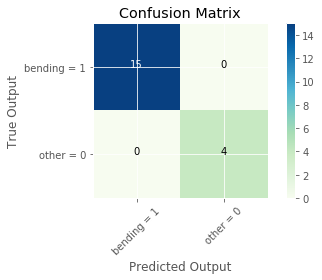

In [71]:
# Confusion Matrix
activities=['bending = 1','other = 0']
plot_confusion_matrix(confusionDown_list[19], classes=activities,
                      normalize=False,
                      title='Confusion Matrix',
                      c_map=plt.get_cmap("GnBu"))

#### ROC and AUC for $\mathit{l}$ = 20 and $\mathit{p}$ = 11

The confusion matrix is: 
[[15  0]
 [ 0  4]]
The AUC is: 1.0


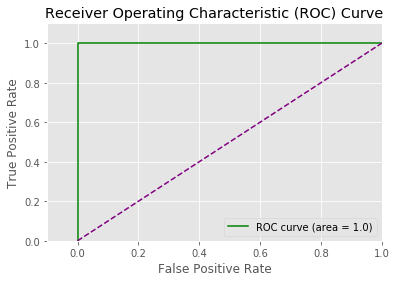

In [72]:
# ROC
print('The confusion matrix is: ')
print(confusionDown_list[19])
print('The AUC is: {}'.format(aucDown_list[19]))

plt.style.use('ggplot')
plt.plot(fprDown_list[19], tprDown_list[19], color='green', label='ROC curve (area = {})'.format(aucDown_list[19]))
plt.plot([0, 1], [0, 1], color='purple', linestyle='--')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## 2 (b) Binary Classifcation Using $\mathscr{L}_1$-Penalized Logistic Regression with $\mathscr{L}_1$ Regularization (Lasso)

In [349]:
# Lasso regression
lassoCV_scores=[]
l_list=[]
l_CVL1_score_list=[]
lambdaCV_list=[]
pNumL1_feature_list=[]
lassoCV_score_list=[]
lassoCV_dict={}
test_scoreL1_list=[]
confusionL1_list=[]
features_selectedL1_list=[]
rocauc_scoreL1_list=[]
fprL1_list=[]
tprL1_list=[]
thresholdsL1_list=[]

for l in range(len(tng_featAll_list)):
    l_list.append(l+1)
    
    X_train = tng_featAll_list[l].iloc[:,1:]
    y_train = tng_featAll_list[l].loc[:,'binaryClass']
    X_test = test_featAll_list[l].iloc[:,1:]
    y_test = test_featAll_list[l].loc[:,'binaryClass']

    # logistic regression model with L1 penalty
    logRegL1_tng = LogisticRegression(penalty='l1',solver='liblinear')
    
    lassoCV_tng = LassoCV(cv=5, normalize=True, max_iter=50000).fit(X_train, y_train)
    lambdaCV = lassoCV_tng.alpha_
    lambdaCV_list.append(lambdaCV)
    pNumL1_features = np.sum(lassoCV_tng.coef_!=0)
    pNumL1_feature_list.append(pNumL1_features)  
    lassoCV_score = lassoCV_tng.score(X_test, y_test)
    lassoCV_score_list.append(lassoCV_score)
    
    features_selectedL1 = [f for f,s in zip(X_train.columns, lassoCV_tng.coef_) if s]
    features_selectedL1_list.append(features_selectedL1)
    
    logRegL1_new = LogisticRegression(penalty='l1', C=1/lambdaCV, solver='liblinear',random_state=19)
    logRegL1_new = logRegL1_new.fit(X_train, y_train)
    test_scoreL1 = logRegL1_new.score(X_test, y_test)
    test_scoreL1_list.append(test_scoreL1)
    
    ytest_predL1 = logRegL1_new.predict(X_test)
    confusionL1 = confusion_matrix(y_test, ytest_predL1)
    confusionL1_list.append(confusionL1)
    
    rocauc_scoreL1 = roc_auc_score(y_test, ytest_predL1)
    rocauc_scoreL1_list.append(rocauc_scoreL1)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, ytest_predL1)
    fprL1_list.append(fpr)
    tprL1_list.append(tpr)
    thresholdsL1_list.append(thresholds)

lassoCV_dict = {'l':l_list, 
                'p':pNumL1_feature_list, 
                'lambda':lambdaCV_list, 
                'Test_Score':test_scoreL1_list,
                'Confusion_Matrix':confusionL1_list,
                'AUC':rocauc_scoreL1_list
             }
df_lassoCV = pd.DataFrame(lassoCV_dict)
df_lassoCV

,l,p,lambda,Test_Score,Confusion_Matrix,AUC
0,1,1,0.021757,1.000000,"[[15, 0], [0, 4]]",1.000
1,2,1,0.022685,1.000000,"[[15, 0], [0, 4]]",1.000
2,3,1,0.024001,1.000000,"[[15, 0], [0, 4]]",1.000
3,4,2,0.024782,1.000000,"[[15, 0], [0, 4]]",1.000
4,5,1,0.023477,1.000000,"[[15, 0], [0, 4]]",1.000
5,6,3,0.022149,1.000000,"[[15, 0], [0, 4]]",1.000
6,7,2,0.021079,1.000000,"[[15, 0], [0, 4]]",1.000
7,8,2,0.021847,1.000000,"[[15, 0], [0, 4]]",1.000
8,9,1,0.022469,1.000000,"[[15, 0], [0, 4]]",1.000
9,10,6,0.009079,1.000000,"[[15, 0], [0, 4]]",1.000


#### This is the primary cell/code used for $\mathscr{L}_1$-penalized logistic regression with $\mathscr{L}_1$ regularization

In [81]:
# Lasso regression
lassoCV_scores=[]
l_list=[]
l_CVL1_score_list=[]
lambdaCV_list=[]
pNumL1_feature_list=[]
lassoCV_score_list=[]
lassoCV_dict={}
test_scoreL1_list=[]
confusionL1_list=[]
features_selectedL1_list=[]
rocauc_scoreL1_list=[]
fprL1_list=[]
tprL1_list=[]
thresholdsL1_list=[]

for l in range(len(tng_featAll_list)):
    l_list.append(l+1)
    
    X_train = tng_featAll_list[l].iloc[:,1:]
    y_train = tng_featAll_list[l].loc[:,'binaryClass']
    X_test = test_featAll_list[l].iloc[:,1:]
    y_test = test_featAll_list[l].loc[:,'binaryClass']

    logRegL1_tng = LogisticRegression(penalty='l1',solver='liblinear')
    
    lassoCV_tng = LassoCV(cv=10, normalize=True, max_iter=50000).fit(X_train, y_train)
    lambdaCV = lassoCV_tng.alpha_
    lambdaCV_list.append(lambdaCV)
    pNumL1_features = np.sum(lassoCV_tng.coef_!=0)
    pNumL1_feature_list.append(pNumL1_features)  
    lassoCV_score = lassoCV_tng.score(X_test, y_test)
    lassoCV_score_list.append(lassoCV_score)
    
    features_selectedL1 = [f for f,s in zip(X_train.columns, lassoCV_tng.coef_) if s]
    features_selectedL1_list.append(features_selectedL1)
    
    logRegL1_new = LogisticRegression(penalty='l1', C=1/lambdaCV, solver='liblinear',random_state=19)
    logRegL1_new = logRegL1_new.fit(X_train, y_train)
    test_scoreL1 = logRegL1_new.score(X_test, y_test)
    test_scoreL1_list.append(test_scoreL1)
    
    ytest_predL1 = logRegL1_new.predict(X_test)
    confusionL1 = confusion_matrix(y_test, ytest_predL1)
    confusionL1_list.append(confusionL1)
    
    rocauc_scoreL1 = roc_auc_score(y_test, ytest_predL1)
    rocauc_scoreL1_list.append(rocauc_scoreL1)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, ytest_predL1)
    fprL1_list.append(fpr)
    tprL1_list.append(tpr)
    thresholdsL1_list.append(thresholds)

lassoCV10_dict = {'l':l_list, 
                'p':pNumL1_feature_list, 
                'lambda':lambdaCV_list, 
                'Test_Score':test_scoreL1_list,
                'Confusion_Matrix':confusionL1_list,
                'AUC':rocauc_scoreL1_list
             }
df_lassoCV10 = pd.DataFrame(lassoCV10_dict)
df_lassoCV10

,l,p,lambda,Test_Score,Confusion_Matrix,AUC
0,1,7,0.002502,1.0,"[[15, 0], [0, 4]]",1.0
1,2,3,0.007965,1.0,"[[15, 0], [0, 4]]",1.0
2,3,9,0.003402,1.0,"[[15, 0], [0, 4]]",1.0
3,4,12,0.004039,1.0,"[[15, 0], [0, 4]]",1.0
4,5,2,0.020419,1.0,"[[15, 0], [0, 4]]",1.0
5,6,16,0.002547,1.0,"[[15, 0], [0, 4]]",1.0
6,7,10,0.005599,1.0,"[[15, 0], [0, 4]]",1.0
7,8,19,0.003321,1.0,"[[15, 0], [0, 4]]",1.0
8,9,14,0.003662,1.0,"[[15, 0], [0, 4]]",1.0
9,10,15,0.003188,1.0,"[[15, 0], [0, 4]]",1.0


In [82]:
# Find the value of l with the highest CV and test scores
df_lassoCV10_min = df_lassoCV10.copy()
df_lassoCV10_min = df_lassoCV10_min[df_lassoCV10_min['Test_Score']==df_lassoCV10_min['Test_Score'].max()]
df_lassoCV10_min = df_lassoCV10_min[df_lassoCV10_min['l']==df_lassoCV10_min['l'].min()]
df_lassoCV10_min

,l,p,lambda,Test_Score,Confusion_Matrix,AUC
0,1,7,0.002502,1.0,"[[15, 0], [0, 4]]",1.0


$\mathscr{L}_1$-penalized logistic regression with $\mathscr{L}_1$ regularization, best ($\mathit{l}$, $\mathit{p}$) pair is $\mathit{l}$ = 1 and $\mathit{p}$ = 7. Resultant regularization parameter $\lambda$ from LassoCV, $\lambda$ = 0.002502.

#### Confusion Matrix for  $\mathit{l}$ = 1 and $\mathit{p}$ = 7

Confusion Matrix
[[15  0]
 [ 0  4]]


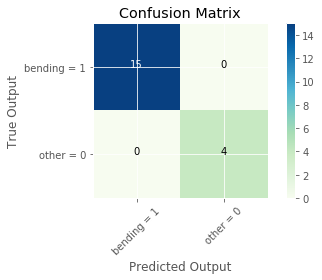

In [109]:
# Confusion Matrix
activities=['bending = 1','other = 0']
plot_confusion_matrix(confusionL1_list[0], classes=activities,
                      normalize=False,
                      title='Confusion Matrix',
                      c_map=plt.get_cmap("GnBu"))

#### ROC for  $\mathit{l}$ = 1 and $\mathit{p}$ = 7

The confusion matrix is: 
[[15  0]
 [ 0  4]]
The AUC is: 1.0


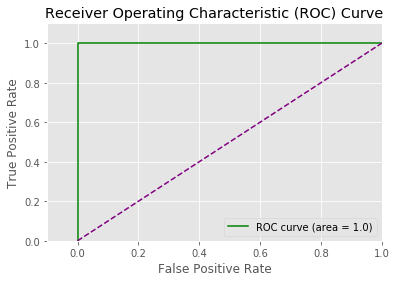

In [85]:
# ROC
print('The confusion matrix is: ')
print(confusionL1_list[0])
print('The AUC is: {}'.format(rocauc_scoreL1_list[0]))

plt.style.use('ggplot')
plt.plot(fprL1_list[0], tprL1_list[0], color='green', label='ROC curve (area = {})'.format(rocauc_scoreL1_list[0]))
plt.plot([0, 1], [0, 1], color='purple', linestyle='--')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [104]:
# Logistic RegressionCV
l_list=[]
lambdaCVLR_list=[]
pNumL1LR_feature_list=[]
test_scoreL1LR_list=[]
confusionL1LR_list=[]
features_selectedL1LR_list=[]
rocauc_scoreL1LR_list=[]
fprL1LR_list=[]
tprL1LR_list=[]
thresholdsL1LR_list=[]

for l in range(len(tng_featAll_list)):
    l_list.append(l+1)
    
    X_train = tng_featAll_list[l].iloc[:,1:]
    y_train = tng_featAll_list[l].loc[:,'binaryClass']
    X_test = test_featAll_list[l].iloc[:,1:]
    y_test = test_featAll_list[l].loc[:,'binaryClass']

    logRegCVL1_tng = LogisticRegressionCV(Cs=100, cv=5, penalty='l1',solver='liblinear', refit=True)
    logRegCVL1_tng.fit(X_train, y_train)
    lambdaCVLR = 1/logRegCVL1_tng.C_
    lambdaCVLR_list.append(lambdaCVLR)
    pNumL1LR_features = np.sum(logRegCVL1_tng.coef_!=0)
    pNumL1LR_feature_list.append(pNumL1LR_features) 
    test_scoreL1LR = logRegCVL1_tng.score(X_test, y_test)
    test_scoreL1LR_list.append(test_scoreL1LR)
    
    features_selectedL1LR = [f for f,s in zip(X_train.columns, logRegCVL1_tng.coef_.ravel()) if s]
    features_selectedL1LR_list.append(features_selectedL1LR)
    
    ytest_predL1LR = logRegCVL1_tng.predict(X_test)
    confusionL1LR = confusion_matrix(y_test, ytest_predL1LR)
    confusionL1LR_list.append(confusionL1LR)
    
    rocauc_scoreL1LR = roc_auc_score(y_test, ytest_predL1LR)
    rocauc_scoreL1LR_list.append(rocauc_scoreL1LR)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, ytest_predL1LR)
    fprL1LR_list.append(fpr)
    tprL1LR_list.append(tpr)
    thresholdsL1LR_list.append(thresholds)

logRegCV_dict = {'l':l_list, 
                'p':pNumL1LR_feature_list, 
                'lambda':lambdaCVLR_list, 
                'Test_Score':test_scoreL1LR_list,
                'Confusion_Matrix':confusionL1LR_list,
                'AUC':rocauc_scoreL1LR_list
             }
df_logRegCV = pd.DataFrame(logRegCV_dict)
df_logRegCV

,l,p,lambda,Test_Score,Confusion_Matrix,AUC
0,1,7,[1.5922827933410906],1.000000,"[[15, 0], [0, 4]]",1.000
1,2,11,[1.5922827933410906],1.000000,"[[15, 0], [0, 4]]",1.000
2,3,14,[0.7564633275546274],1.000000,"[[15, 0], [0, 4]]",1.000
3,4,16,[0.2477076355991709],0.947368,"[[15, 0], [1, 3]]",0.875
4,5,177,[0.00030538555088334125],0.947368,"[[15, 0], [1, 3]]",0.875
5,6,18,[0.2983647240283334],1.000000,"[[15, 0], [0, 4]]",1.000
6,7,262,[0.0001],0.947368,"[[15, 0], [1, 3]]",0.875
7,8,273,[0.0001450828778495937],0.947368,"[[15, 0], [1, 3]]",0.875
8,9,8,[8.497534359086439],0.947368,"[[15, 0], [1, 3]]",0.875
9,10,28,[0.4328761281083052],0.947368,"[[15, 0], [1, 3]]",0.875


In [106]:
# Find the value of l with the highest CV and test scores
df_logRegCV_min = df_logRegCV.copy()
df_logRegCV_min = df_logRegCV_min[df_logRegCV_min['Test_Score']==df_logRegCV_min['Test_Score'].max()]
df_logRegCV_min = df_logRegCV_min[df_logRegCV_min['l']==df_logRegCV_min['l'].min()]
df_logRegCV_min 

,l,p,lambda,Test_Score,Confusion_Matrix,AUC
0,1,7,[1.5922827933410906],1.0,"[[15, 0], [0, 4]]",1.0


$\mathscr{L}_1$-penalized logistic regression with $\mathscr{L}_1$ regularization, best ($\mathit{l}$, $\mathit{p}$) pair is  $\mathit{l}$ = 1 and $\mathit{p}$ = 7.

#### Confusion Matrix for  $\mathit{l}$ = 1 and $\mathit{p}$ = 7

Confusion Matrix
[[15  0]
 [ 0  4]]


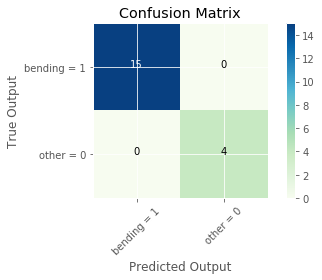

In [110]:
# Confusion Matrix
activities=['bending = 1','other = 0']
plot_confusion_matrix(confusionL1LR_list[0], classes=activities,
                      normalize=False,
                      title='Confusion Matrix',
                      c_map=plt.get_cmap("GnBu"))

#### ROC for  $\mathit{l}$ = 1 and $\mathit{p}$ = 7

The confusion matrix is: 
[[15  0]
 [ 0  4]]
The AUC is: 1.0


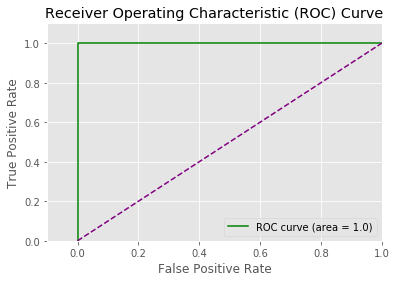

In [112]:
# ROC
print('The confusion matrix is: ')
print(confusionL1LR_list[0])
print('The AUC is: {}'.format(rocauc_scoreL1LR_list[0]))

plt.style.use('ggplot')
plt.plot(fprL1LR_list[0], tprL1LR_list[0], color='green', label='ROC curve (area = {})'.format(rocauc_scoreL1LR_list[0]))
plt.plot([0, 1], [0, 1], color='purple', linestyle='--')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### 2 (b) ii. Compare the $\mathscr{L}_1$-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

Using backward selection via RFE and RFECV or by conducting $\mathscr{L}_1$-penalized logistic regression was easier to implement.

With regards to performance, conducting $\mathscr{L}_1$-penalized logistic regression and backward selection with scikit-learn's recursive feature elimination class (RFE and RFECV) performed quite similarly. The best test score, confusion matrix, ROC, and AUC were all the same. There were some small differences in the test scores for backward selection, but there was not a big enough difference to make a considerable impact. 

## 2 (c) Multi-class Classification (The Realistic Case)

### Training Set

In [86]:
tng_activityCol = findActivity(training_dict)
tng_activityNumCol = findActivityNum(training_dict)
tng_featAllActivity_list = deepcopy(tng_featAll_list)
for tngSet in tng_featAllActivity_list:
    tngSet.insert(loc=0, column='activityNum', value=tng_activityNumCol)
    tngSet.insert(loc=0, column='activity', value=tng_activityCol)

In [87]:
tng_featAllActivity_list[9].head()

,activity,activityNum,binaryClass,min1,max1,mean1,median1,std_dev1,1st_quart1,3rd_quart1,...,std_dev59,1st_quart59,3rd_quart59,min60,max60,mean60,median60,std_dev60,1st_quart60,3rd_quart60
Instance,,,,,,,,,,,,,,,,,,,,,
1,bending,1,1,40.00,45.00,44.025833,44.500,1.281888,43.750,45.0000,...,0.187676,36.0000,36.0000,0.0,1.30,0.129792,0.000,0.271932,0.00,0.00
2,bending,1,1,36.00,47.75,44.220417,45.125,3.291462,43.730,46.3725,...,3.440678,25.9175,30.5425,0.0,1.50,0.529583,0.430,0.505038,0.00,0.87
3,bending,1,1,36.00,45.00,41.670417,42.000,2.113836,40.375,42.7500,...,1.095713,26.5000,27.0000,0.0,1.00,0.329167,0.430,0.281401,0.00,0.50
4,bending,1,1,41.00,46.75,44.857500,45.000,0.877049,45.000,45.0000,...,3.580606,21.0000,24.0000,0.0,4.06,0.663333,0.485,0.819227,0.00,0.84
5,bending,1,1,40.75,44.50,43.033750,43.165,1.021629,42.000,43.7500,...,0.953537,22.0000,23.6375,0.0,1.73,0.617083,0.500,0.390215,0.43,0.84


### Test Set

In [88]:
test_activityCol = findActivity(test_dict)
test_activityNumCol = findActivityNum(test_dict)
test_featAllActivity_list = deepcopy(test_featAll_list)
for testSet in test_featAllActivity_list:
    testSet.insert(loc=0, column='activityNum', value=test_activityNumCol)
    testSet.insert(loc=0, column='activity', value=test_activityCol)

In [89]:
test_featAllActivity_list[9].head()

,activity,activityNum,binaryClass,min1,max1,mean1,median1,std_dev1,1st_quart1,3rd_quart1,...,std_dev59,1st_quart59,3rd_quart59,min60,max60,mean60,median60,std_dev60,1st_quart60,3rd_quart60
Instance,,,,,,,,,,,,,,,,,,,,,
1,bending,1,1,39.00,41.75,40.401250,40.500,0.868955,39.50,41.0000,...,2.261801,30.0000,32.4375,0.00,1.50,0.407292,0.430,0.458461,0.0000,0.5525
2,bending,1,1,41.75,44.25,43.425417,43.500,0.400696,43.33,43.6700,...,0.979885,31.1875,33.0000,0.00,1.50,0.357708,0.430,0.389791,0.0000,0.5000
3,bending,1,1,14.00,24.75,20.637083,21.125,2.696175,19.00,22.3550,...,1.176657,20.3300,21.3475,0.00,1.25,0.601250,0.500,0.296581,0.4300,0.8300
4,bending,1,1,26.50,30.00,27.796667,27.000,1.292899,27.00,29.3300,...,4.976857,22.0000,29.0000,0.00,6.68,2.076875,1.455,1.553238,0.9125,3.2875
5,cycling,2,0,30.75,44.50,36.751667,35.625,3.974684,33.25,40.5625,...,2.553277,18.3750,21.6900,0.43,8.17,2.728333,2.355,1.821727,1.3825,3.6700


### 2 (c) i. Find the Best $\mathit{l}$ via Multi-Class Classification

In [91]:
# Multi-class classification
lassoCV_scores=[]
l_list=[]
l_CVL1multi_score_list=[]
lambdaCVmulti_list=[]
pNumL1multi_feature_list=[]
lassoCVmulti_score_list=[]
lassoCVmulti_dict={}
test_scoreL1multi_list=[]
confusionL1multi_list=[]
features_selected_multi_list=[]
l_CVL1_score_list=[]
rocauc_scoreL1multi_list=[]
test_errorL1multi_list=[]

for l in range(len(tng_featAllActivity_list)):
    l_list.append(l+1)
    
    X_train = tng_featAllActivity_list[l].iloc[:,3:]
    y_train = tng_featAllActivity_list[l].loc[:,'activityNum']
    X_test = test_featAllActivity_list[l].iloc[:,3:]
    y_test = test_featAllActivity_list[l].loc[:,'activityNum']

    logRegL1multi_tng = LogisticRegression(penalty='l1',solver='saga', multi_class='multinomial', max_iter=100000)
    
    lassoCVmulti_tng = LassoCV(cv=StratifiedKFold(5), normalize=True, max_iter=100000).fit(X_train, y_train)
    
    lambdaCVmulti = lassoCVmulti_tng.alpha_
    lambdaCVmulti_list.append(lambdaCVmulti)
    
    pNumL1multi_features = np.sum(lassoCVmulti_tng.coef_!=0)
    pNumL1multi_feature_list.append(pNumL1multi_features)  
    
    lassoCVmulti_score = lassoCVmulti_tng.score(X_test, y_test)
    lassoCVmulti_score_list.append(lassoCVmulti_score)
    
    features_selected_multi = [f for f,s in zip(X_train.columns, lassoCV_tng.coef_) if s]
    features_selected_multi_list.append(features_selected_multi)

    logRegL1multi_new = LogisticRegression(penalty='l1', C=1/lambdaCVmulti, solver='saga', multi_class='multinomial', max_iter=100000)
    logRegL1multi_new = logRegL1multi_new.fit(X_train, y_train)
    test_scoreL1multi = logRegL1multi_new.score(X_test, y_test)
    test_scoreL1multi_list.append(test_scoreL1multi)
    test_errorL1multi = 1-test_scoreL1multi
    test_errorL1multi_list.append(test_errorL1multi)

    ytest_predL1multi = logRegL1multi_new.predict(X_test) #predict the y
    confusionL1multi = confusion_matrix(y_test, ytest_predL1multi, labels=[1,2,3,4,5,6])
    confusionL1multi_list.append(confusionL1multi)

lassoCVmulti_dict = {'l':l_list, 
                     'p':pNumL1multi_feature_list, 
                     'lambda':lambdaCVmulti_list, 
                     'Test_Score':test_scoreL1multi_list,
                     'Test Error':test_errorL1multi_list
                     }
df_lassoCVmulti = pd.DataFrame(lassoCVmulti_dict)
df_lassoCVmulti

,l,p,lambda,Test_Score,Test Error
0,1,10,0.004917,0.894737,0.105263
1,2,13,0.012355,0.947368,0.052632
2,3,21,0.009941,0.894737,0.105263
3,4,20,0.010592,0.947368,0.052632
4,5,28,0.009466,0.894737,0.105263
5,6,33,0.005887,0.842105,0.157895
6,7,27,0.011853,0.789474,0.210526
7,8,20,0.020893,0.842105,0.157895
8,9,22,0.018352,0.842105,0.157895
9,10,25,0.015358,0.894737,0.105263


In [92]:
df_lassoCVmulti_min = df_lassoCVmulti.copy()
df_lassoCVmulti_min = df_lassoCVmulti_min[df_lassoCVmulti_min['Test_Score']==df_lassoCVmulti_min['Test_Score'].max()]
df_lassoCVmulti_min = df_lassoCVmulti_min[df_lassoCVmulti_min['l']==df_lassoCVmulti_min['l'].min()]
df_lassoCVmulti_min

,l,p,lambda,Test_Score,Test Error
1,2,13,0.012355,0.947368,0.052632


The dataframe above shows that the best ($\mathit{l}$, $\mathit{p}$) pair via multi-class classification with an $\mathscr{L}_1$-penalized multinomial regression are $\mathit{l}$ = 2 $\mathit{p}$ = 13.

By using $\mathscr{L}_1$-penalized multinomial regression with $\mathscr{L}_1$ regularization, our best ($\mathit{l}$, $\mathit{p}$) pair were $\mathit{l}$ = 2 and $\mathit{p}$ = 13 with $\lambda$ = 0.012355.

With regards to the confusion matrix and the ROC curve, I was able to calculate and provide a confusion matrix below, but I was unable to show the ROC curve.

#### Confusion Matrix for  $\mathit{l}$ = 2 and $\mathit{p}$ = 13

Confusion Matrix
[[3 0 0 1 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 3]]


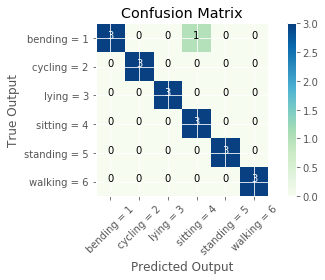

In [93]:
activities=['bending = 1','cycling = 2','lying = 3','sitting = 4','standing = 5','walking = 6']
plot_confusion_matrix(confusionL1multi_list[1], classes=activities,
                      normalize=False,
                      title='Confusion Matrix',
                      c_map=plt.get_cmap("GnBu"))

### 2 (c) ii. Naive Bayes' classifier. Use both Gaussian and Multinomial priors and compare the results.

In [94]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

#### Gaussian Naive Bayes

In [95]:
l_list=[]
test_scoreGNB_list=[]
test_errorGNB_list=[]
confusionGNB_list=[]
rocauc_scoreGNB_list=[]

for l in range(len(tng_featAllActivity_list)):
    l_list.append(l+1)
    
    X_train = tng_featAllActivity_list[l].iloc[:,3:]
    y_train = tng_featAllActivity_list[l].loc[:,'activityNum']
    X_test = test_featAllActivity_list[l].iloc[:,3:]
    y_test = test_featAllActivity_list[l].loc[:,'activityNum']
    
    # Fit a GaussianNB model
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    ytest_predGNB = gnb.predict(X_test)
    
    test_scoreGNB = gnb.score(X_test, y_test)
    test_scoreGNB_list.append(test_scoreGNB)
    
    test_errorGNB = 1-test_scoreGNB
    test_errorGNB_list.append(test_errorGNB)

    confusionGNB = confusion_matrix(y_test, ytest_predGNB, labels=[1,2,3,4,5,6])
    confusionGNB_list.append(confusionGNB)
    
gnb_dict = {'l':l_list, 
            'Test_Score':test_scoreGNB_list,
            'Test_Error':test_errorGNB_list
            }
df_gnb = pd.DataFrame(gnb_dict)
df_gnb

,l,Test_Score,Test_Error
0,1,0.894737,0.105263
1,2,0.842105,0.157895
2,3,0.789474,0.210526
3,4,0.894737,0.105263
4,5,0.894737,0.105263
5,6,0.789474,0.210526
6,7,0.789474,0.210526
7,8,0.789474,0.210526
8,9,0.842105,0.157895
9,10,0.842105,0.157895


In [96]:
df_gnb_min = df_gnb.copy()
df_gnb_min = df_gnb_min[df_gnb_min['Test_Score']==df_gnb_min['Test_Score'].max()]
df_gnb_min = df_gnb_min[df_gnb_min['l']==df_gnb_min['l'].min()]
df_gnb_min

,l,Test_Score,Test_Error
0,1,0.894737,0.105263


Our highest test score (smallest test error) was found when the time series was split $\mathit{l}$ = 1 time.

Confusion Matrix
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [1 0 2 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]


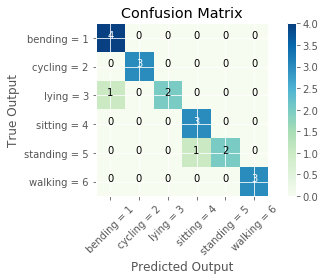

In [97]:
# GaussianNB confusion matrix for the best l
activities=['bending = 1','cycling = 2','lying = 3','sitting = 4','standing = 5','walking = 6']
plot_confusion_matrix(confusionGNB_list[0], classes=activities,
                      normalize=False,
                      title='Confusion Matrix',
                      c_map=plt.get_cmap("GnBu"))

#### Multinomial Naive Bayes

In [98]:
l_list=[]
test_scoreMNB_list=[]
test_errorMNB_list=[]
confusionMNB_list=[]

for l in range(len(tng_featAllActivity_list)):
    l_list.append(l+1)
    
    X_train = tng_featAllActivity_list[l].iloc[:,3:]
    y_train = tng_featAllActivity_list[l].loc[:,'activityNum']
    X_test = test_featAllActivity_list[l].iloc[:,3:]
    y_test = test_featAllActivity_list[l].loc[:,'activityNum']
    
    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)
    ytest_predMNB = mnb.predict(X_test)
    
    test_scoreMNB = mnb.score(X_test, y_test)
    test_scoreMNB_list.append(test_scoreMNB)
    
    test_errorMNB = 1-test_scoreMNB
    test_errorMNB_list.append(test_errorMNB)
    
    confusionMNB = confusion_matrix(y_test, ytest_predMNB, labels=[1,2,3,4,5,6])
    confusionMNB_list.append(confusionMNB)
    
mnb_dict = {'l':l_list, 
            'Test_Score':test_scoreMNB_list,
            'Test_Error':test_errorMNB_list
            }
df_mnb = pd.DataFrame(mnb_dict)
df_mnb

,l,Test_Score,Test_Error
0,1,0.894737,0.105263
1,2,0.842105,0.157895
2,3,0.842105,0.157895
3,4,0.842105,0.157895
4,5,0.842105,0.157895
5,6,0.842105,0.157895
6,7,0.842105,0.157895
7,8,0.842105,0.157895
8,9,0.842105,0.157895
9,10,0.842105,0.157895


In [99]:
df_mnb_min = df_mnb.copy()
df_mnb_min = df_mnb_min[df_mnb_min['Test_Score']==df_mnb_min['Test_Score'].max()]
df_mnb_min = df_mnb_min[df_mnb_min['l']==df_mnb_min['l'].min()]
df_mnb_min

,l,Test_Score,Test_Error
10,11,0.947368,0.052632


Our highest test score (smallest test error) was found when the time series was split $\mathit{l}$ = 11 times.

Additionally, below is the confusion matrix for $\mathit{l}$ = 11

Confusion Matrix
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 3]]


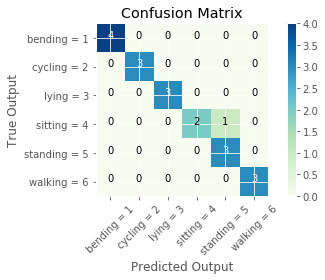

In [100]:
# MultinomialNB confusion matrix for the best l
activities=['bending = 1','cycling = 2','lying = 3','sitting = 4','standing = 5','walking = 6']
plot_confusion_matrix(confusionMNB_list[10], classes=activities,
                      normalize=False,
                      title='Confusion Matrix',
                      c_map=plt.get_cmap("GnBu"))

#### Compare the Results of GaussianNB and MultinomialNB
The cell below shows the best result from GaussianNB

In [101]:
# For Gaussian NB, show the data set that had the best test score/error and the least number of l splits
df_gnb_min

,l,Test_Score,Test_Error
0,1,0.894737,0.105263


The cell below shows the best result from MultinomialNB

In [102]:
# For MultinomialNB, show the data set that had the best test score/error and the least number of l splits
df_mnb_min

,l,Test_Score,Test_Error
10,11,0.947368,0.052632


As seen in the output above, the results of the MultinomialNB produced a higher test score (lower test error) when the time series was split $\mathit{l}$ = 11 times.

### 2 (c) iii. Which method is better for multi-class classification in this problem?
The cell below shows the best result from $\mathscr{L}_1$-penalized multinomial regression with $\mathscr{L}_1$ regularization using LassoCV and LogisitcRegression with the $\lambda$ from LassoCV.

In [103]:
df_lassoCVmulti_min

,l,p,lambda,Test_Score,Test Error
1,2,13,0.012355,0.947368,0.052632


In comparing the three results from our multi-class classification problem, the $\mathscr{L}_1$-penalized multinomial regression with $\mathscr{L}_1$ regularization and the multinomial Naives Bayes' classifier had the highest test scores (lowest errors). As we can see in the dataframes above, the test scores for both of those methods proved to perform well with equivalent test scores = 0.947368.

With regrads to ease of use and how computationally expensive these methods were, the multinomial and Gaussian Naives Bayes' classifiers were much easier and faster to use than any other multi-class classification method.

## ISLR 4.8.3
**This problem relates to the QDA model, in which the observations within each class are drawn from a normal distribution with a class specific mean vector and a class specific covariance matrix. We consider the simple case where p = 1; i.e. there is only one feature.**

**Suppose that we have K classes, and that if an observation belongs to the kth class then X comes from a one-dimensional normal distribution, $X ∼ N(\mu k, \sigma^2_k)$. Recall that the density function for the one-dimensional normal distribution is given in (4.11). Prove that in this case, the Bayes’ classifier is not linear. Argue that it is in fact quadratic.**

**_Hint: For this problem, you should follow the arguments laid out in Section 4.4.2, but without making the assumption that $\sigma^2_1 = . . . = \sigma^2_k$._**

#### <u>GIVEN</u>:
$Pr(Y=k|X=x) = \frac{\pi_k f_k (x)}{\sum^K_{l=1} \pi_l f_l (x)} \quad$ Bayes Theorm (4.10) 

$\pi_k$ is the prior probability that an observation belongs to the kth class


$f_x (x) = \frac{1}{\sqrt{2 \pi}\sigma_k} exp(- \frac{1}{2\sigma^2_k}(x-\mu_k)^2) \quad$ Density function for the one-dimensional normal distribution (4.11) 

$\mu_k$ is the mean for the kth class

$\sigma^2_k$ is the variance for the kth class

p=1 (there is only one feature)

#### <u>SOLVE</u>:
Substitute 4.11 in 4.10

$p_k(x) = \frac{\pi_k \frac {1}{\sqrt{2 \pi}\sigma_k} \exp(- \frac{1}{2\sigma_k^2} (x-\mu_k)^2)} {\sum^K_{l=1} {\pi_l \frac{1}{\sqrt{2 \pi}\sigma_l} \exp(-\frac{1}{2\sigma_l^2}(x-\mu_l)^2)}}$


Take the log of both sides

$\log(p_k(x)) = \log \bigg{(}\frac{\pi_k \frac {1}{\sqrt{2 \pi}\sigma_k} \exp(- \frac{1}{2\sigma_k^2} (x-\mu_k)^2)} {\sum^K_{l=1} {\pi_l \frac{1}{\sqrt{2 \pi}\sigma_l} \exp(-\frac{1}{2\sigma_l^2}(x-\mu_l)^2)}} \bigg{)}$

Based on the log rules, simplify the log terms

$\log(p_k(x)) = \frac{\log({\pi_k}) + \log\big{(}{\frac{1}{\sqrt{2 \pi}\sigma_k}}\big{)} + \log\big{(}{\exp(- \frac{1}{2\sigma_k^2} (x-\mu_k)^2)}\big{)}} {\log\big{(}\sum^K_{l=1} {\pi_l \frac{1}{\sqrt{2 \pi}\sigma_l} \exp(-\frac{1}{2\sigma_l^2}(x-\mu_l)^2)}\big{)}} $

$\log(p_k(x)) = \frac{\log({\pi_k}) + \log\big{(}{\frac{1}{\sqrt{2 \pi}\sigma_k}}\big{)} + \big{(}{- \frac{1}{2\sigma_k^2} (x-\mu_k)^2}\big{)}} {\log\big{(}\sum^K_{l=1} {\pi_l \frac{1}{\sqrt{2 \pi}\sigma_l} \exp(-\frac{1}{2\sigma_l^2}(x-\mu_l)^2)}\big{)}} $

$\log(p_k(x)) * {\log\big{(}\sum^K_{l=1} {\pi_l \frac{1}{\sqrt{2 \pi}\sigma_l} \exp(-\frac{1}{2\sigma_l^2}(x-\mu_l)^2)}\big{)}}  = {\log({\pi_k}) + \log\big{(}{\frac{1}{\sqrt{2 \pi}\sigma_k}}\big{)} - \big{(}{\frac{(x-\mu_k)^2}{2\sigma_k^2} }\big{)}} $

#### <u>CONCLUSION</u>:
There is a quadratic term $(x-\mu_k)^2$ in the equation and so it is not linear.

## ISLR 4.8.7
**Suppose that we wish to predict whether a given stock will issue a dividend this year (“Yes” or “No”) based on X, last year’s percent profit. We examine a large number of companies and discover that the mean value of X for companies that issued a dividend was $\bar{X} = 10$, while the mean for those that didn’t was $\bar{X} = 0$. In addition, the variance of X for these two sets of companies was $\hat{\sigma}^2 = 36$. Finally, 80% of companies issued dividends. Assuming that X follows a normal distribution, predict the probability that a company will issue a dividend this year given that its percentage profit was X = 4 last year.**

**_Hint: Recall that the density function for a normal random variable is $f(x) = \frac{1}{\sqrt{2\pi \sigma^2}} e^{−(x−\mu)^2/2\sigma^2}$. You will need to use Bayes’ theorem._**

#### <u>Just like in ISLR 4.7.3, substitute 4.11 into 4.10</u>

$p_k(x) = \frac{\pi_k \frac{1}{\sqrt{2 \pi}\sigma_k} \exp(- \frac{1}{2\sigma_k^2} (x-\mu_k)^2)} {\sum^K_{l=1} {\pi_l \frac{1}{\sqrt{2 \pi}\sigma_k} \exp(-\frac{1}{2\sigma_k^2}(x-\mu_l)^2)}}$

#### <u>GIVEN</u>:

$\mu_{yes} = 10$; the mean for companies that issued a dividend

$\mu_{no} = 0$; the mean for companies that did not issue a dividend

$\sigma^2 = 36$; the variance for these two sets

$\pi_{yes} = 0.8$ or 80%; the prior probability where companies issued dividends

$\pi_{no} = 1-\pi_{yes} = 1-0.8 = 0.2$; the prior probability where companies did not issue dividends

$x = 4$

#### <u>SOLVE</u>:
Substitute our given values into $p_k(x)$

$p_{yes}(4) = \frac{0.8 \frac{1}{\sqrt{2 \pi}\sigma_k} \exp(- \frac{1}{2*36} (4-10)^2)} {0.8 \frac{1}{\sqrt{2 \pi}\sigma_k} \exp(-\frac{1}{2*36}(4-10)^2) + (1-0.8) \frac{1}{\sqrt{2 \pi}\sigma_k} \exp(-\frac{1}{2*36}(4-0)^2)}$

Cancel $\frac{1}{\sqrt{2 \pi}\sigma_k}$ out of all terms in the numerator and denominator

$p_{yes}(4) = \frac{0.8 \exp(- \frac{1}{2*36} (4-10)^2)} {0.8 \exp(-\frac{1}{2*36}(4-10)^2) + (1-0.8) \exp(-\frac{1}{2*36}(4-0)^2)}$

Simplify

$p_{yes}(4) = \frac{0.8\exp(- \frac{36}{72})} {0.8\exp(-\frac{36}{72}) + 0.2\exp(-\frac{16}{72})}$

$p_{yes}(4) = \frac{0.8\exp(- \frac{1}{2})} {0.8\exp(-\frac{1}{2}) + 0.2\exp(-\frac{2}{9})}$

Using a calculator to evalute the remaining terms:

$p_{yes}(4) = 0.75185$ or 75.19%

#### <u>CONCLUSION</u>:
Given that a company's percentage profit was X = 4 last year, the probability that a company will issue a dividend this year is 75.19%.